### Figure 3: Cluster Anslysis and Spatio-temporal evolution of dynamic topography

In [1]:
import xarray as xr
import rioxarray as rxr
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
import pygmt
#import pygplates
import seaborn as sns
import geopandas as gpd
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
def elbow_plot(modelname, df):
    """
    This function plot the within cluster sum of square (wccs) vs number of clusters to
    generate elbow plot.

    Parameters:
    -modelname : name of model
    -df: truncated dataframe of flattened dataframe (time, (lon*lat))

    Returns:
    None, displays elbow plot

    """
    
    k_range = range(1, 10)  # Check cluster sizes from 1 to 10
    data2D_woindex = df.loc[:, 0:].values
    fig, axes = plt.subplots(1, figsize= (10,8))
    #for i, data_2d  in enumerate([mod_df_gld504.loc[:,0:].values, mod_df_gld428.loc[:,0:].values]):
    inertias = []   
    for k in k_range:
        model = KMeans(n_clusters=k,  random_state=0)
        model.fit(data2D_woindex)
        inertias.append(model.inertia_)  # Store inertia (WCSS)

    # Plot the inertia (WCSS) for each value of k
    axes.plot(k_range, inertias, marker='o', linestyle='-', color='b')
    axes.set_title(f'Elbow Method for Optimal Number of Clusters -{modelname}')
    axes.set_xlabel('Number of Clusters (k)')
    axes.set_ylabel('Inertia (WCSS)')
    axes.grid(True)
    return fig
    
plt.show()

In [3]:
def data_preprocessing(nc):

    """
    This function preprocesses to transform nc file to 2D dataframe with original index and 
    truncated dataframe with nan dropped.

    Parameteres:
    -nc : takes in time stacked xarray dataarrays/ds

    Returns:
    -org_df : the original flattened dataframe with nan values
    -trunc_df : nan removed dataframe (as KMeans clustering approach does not accept nan values)

    """
    
    array = nc.z.values.reshape(((nc.age.size, -1)))

    #preserve original dataframe and index
    org_df= pd.DataFrame(array).T.reset_index()

    #df with truncated/imputed nans
    df_trunc =  org_df.dropna()

    return org_df, df_trunc

In [4]:
def kmeans_clustering(df, n_clusters=4):
    """
    This function clusters the dataset into specified numbers of cluster using KMeans.

    Parameters:
    -df: truncated dataframe obtained from preprocessing step
    -n_clusters : number of clusters to be labelled for provided data

    Returns:
    -df : input dataframe with added column mapping clusters to timeseries.

    """
    scaler = StandardScaler()
    #print(df.head())
    df_scaled = pd.DataFrame(scaler.fit_transform(df.loc[:,0:]), columns=df.columns[1:])
    #n_clusters = 4  # Number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
            
    #labels= kmeans.fit_predict(df.loc[:, 0:].values)
    labels = kmeans.fit_predict(df_scaled)
    df['clusters'] = labels
    return df

In [5]:
import re

# Optimized function that extracts the age and sorts the file paths
def sort_files_by_age(fpaths, match_string='Ma'):
    """
    This function extracts ages from file paths and sorts them chronologically.

    Parameters:
    fpaths: list of file paths
    match_string: the string to match before the age (default is 'Ma')

    Returns:
    Dictionary with the extracted age as the key and the sorted file paths as values
    """
    # Use a generator to extract ages and pair them with file paths
    def extract_age(file_name):
        match = re.search(f'{match_string}(\d+).', file_name)
        return int(match.group(1)) if match else float('inf')  # return inf if no match is found

    # Sort the file paths by the extracted age using a generator expression
    sorted_files = sorted(fpaths, key=lambda x: extract_age(x))
    
    # Return a dictionary with the age as the key and the file path as the value
    return {extract_age(file): file for file in sorted_files}

In [6]:
#Read and load dynamic topography nc files and stack them up across age dimension
def filepath_to_nc(fpaths):
    """
    This function takes nc file fpaths and returns a single nc file stacked over age/time dimension

    Parameters:
    fpath: list of filepaths locating nc file for gld models spaced [X] Ma simulations
    
    Returns:
    single ncfile with stacked time dimension
    """
    #nc_files = [xr.open_dataset(value).assign(age=[key]) for key, value in fpaths.items()]  # original
    #added on 05 June 2025 to select DT on 20 Myr gaps
    nc_files = [xr.open_dataset(value).assign(age=[key]) for key, value in fpaths.items() if key in range(0,940, 20) and key != 200]
    ncfiles = xr.concat(nc_files, dim='age')
    if 'lon' in ncfiles.dims:
        ncfiles=ncfiles
    else:
        ncfiles = ncfiles.rename({'x':'lon', 'y':'lat'})
    return ncfiles

In [7]:
def data_postprocessing(org_df, truncated_df,nc):
    clustered_df = org_df.merge(truncated_df.loc[:,['index', 'clusters']], on ='index', how='outer').sort_values('index')
    #reshape to lat, lon to create ncfile
    cluster_2d = clustered_df.iloc[:, -1].values.reshape((nc.lat.size, nc.lon.size))

    nc['cluster'] = (['lat', 'lon'], cluster_2d)
    
    return nc

In [70]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages


models =['gld421', 'gld428', 'gld431', 'gld434','gld486', 'gld504',] #[ 'gld428', 'gld504', 'gld560', 'gld563', 'gld564', 'gld565'] #['gld504', 'gld428']
window =slice(420,920)  # change window as required; Here it was run for 420-920 and 0-420
gap = 20

clustered_data =[]
ncs_NA =[]
ncs_BAL=[]
n_clusterss=[2,3]
for n_clusters in n_clusterss:
    for i, model in enumerate(models):
        if model == 'gld504':
            #file_paths =glob.glob(f'.././Model_data/{model}/PlateFrameGrid/**PlateFrameGrid*.nc',)
            file_paths =glob.glob(f'Input_Data_Cluster/{model}/PlateFrameGrid/**PlateFrameGrid*.nc',)
            #n_clusters =4
        elif model == 'gld428':
            # file_paths = glob.glob(f'.././Model_data/{model}/PlateFrameGrid/**PlateFrameGrid*.nc',)
            file_paths = glob.glob(f'Input_Data_Cluster/{model}/PlateFrameGrid/**PlateFrameGrid*.nc',)
            #n_clusters=4
        else:
            #file_paths = glob.glob(f'.././Model_data/{model}/PlateFrameGrid/**PlateFrameGrid*.nc',)
            file_paths = glob.glob(f'Input_Data_Cluster/{model}/PlateFrameGrid/**PlateFrameGrid*.nc',)
            #n_clusters =4
        sorted_filepaths = sort_files_by_age(file_paths, match_string ='Grid')
    
        #----------------------------For North America---------------------------------------------#
        #file_paths_NA = glob.glob(f'.././Model_data/{model}/PlateFrameGrid_NA/**PlateFrameGrid*.nc',)
        file_paths_NA = glob.glob(f'Input_Data_Cluster/{model}/PlateFrameGrid_NA/**PlateFrameGrid*.nc',)
        sorted_filepaths_NA = sort_files_by_age(file_paths_NA, match_string ='Grid')
        nc_full_NA  = filepath_to_nc(sorted_filepaths_NA) #for all time frame
        nc_windows_NA = ncs_NA.append(nc_full_NA.sel(age=window))
        f_path_NA =f'./ClusterAnalysis/NA_{model}_{window.start}-{window.stop}_{n_clusters}.nc'
        if os.path.exists(f_path_NA):
            os.remove(f_path_NA)
        nc_full_NA.sel(age=window).to_netcdf(f'./ClusterAnalysis/NA_{model}_{window.start}-{window.stop}.nc')
    
        #-----------------------------For BALTICA-------------------------------------------------#
        #file_paths_BAL = glob.glob(f'.././Model_data/{model}/PlateFrameGrid_BAL/**PlateFrameGrid*.nc',)
        file_paths_BAL = glob.glob(f'Input_Data_Cluster/{model}/PlateFrameGrid_BAL/**PlateFrameGrid*.nc',)
        sorted_filepaths_BAL = sort_files_by_age(file_paths_BAL, match_string ='Grid')
        nc_full_BAL  = filepath_to_nc(sorted_filepaths_BAL) #for all time frame
        nc_windows_BAL = ncs_BAL.append(nc_full_BAL.sel(age=window))
        f_path_BAL =f'./ClusterAnalysis/BAL_{model}_{window.start}-{window.stop}_{n_clusters}.nc'
        if os.path.exists(f_path_BAL):
            os.remove(f_path_BAL)
        nc_full_BAL.sel(age=window).to_netcdf(f'./ClusterAnalysis/BAL_{model}_{window.start}-{window.stop}.nc')
    
    
        nc_full  = filepath_to_nc(sorted_filepaths) #for all time frame
            
        nc_windows = nc_full.sel(age=window)
    
        # mask file
        nc_920 = nc_full.sel(age=920)
        mask = xr.where(np.isnan(nc_920.z), np.nan, 1)
    
        #masked_files
        nc_masked = nc_windows.where(mask == 1)
        
        #call preprocessing func
        org_df, trunc_df = data_preprocessing(nc_masked)
    
        #save truncated dfs for elbowplots later
        elbow_plot_data_path = f'./ClusterAnalysis/elbow_plots_data/'
        if not os.path.exists(elbow_plot_data_path): 
            os.mkdir(elbow_plot_data_path)
        trunc_df.to_csv(elbow_plot_data_path+f'{model}_{gap}gap_{window.start}-{window.stop}_{n_clusters}_df.csv')
    
        print(model)
        # plot elbow
        #elbow_fig= elbow_plot(model, trunc_df)
        
    
        #compute kmeans
        kmeans_df = kmeans_clustering(trunc_df, n_clusters)
        
    
        #postprocess data to generate clustered nc file
        clustered_nc = data_postprocessing(org_df, trunc_df, nc_masked)
        
        
        f_path_cluster =f'./ClusterAnalysis/cluster_{model}_{window.start}-{window.stop}_{n_clusters}.nc'
        if os.path.exists(f_path_cluster):
            os.remove(f_path_cluster)
            print(f"File '{f_path_cluster}' has been removed.")
        clustered_nc.to_netcdf(f'./ClusterAnalysis/cluster_{model}_{window.start}-{window.stop}_{n_clusters}.nc')
        clustered_data.append(clustered_nc)

gld421
File './ClusterAnalysis/cluster_gld421_420-920_2.nc' has been removed.
gld428
File './ClusterAnalysis/cluster_gld428_420-920_2.nc' has been removed.
gld431
File './ClusterAnalysis/cluster_gld431_420-920_2.nc' has been removed.
gld434
File './ClusterAnalysis/cluster_gld434_420-920_2.nc' has been removed.
gld486
File './ClusterAnalysis/cluster_gld486_420-920_2.nc' has been removed.
gld504
File './ClusterAnalysis/cluster_gld504_420-920_2.nc' has been removed.
gld421
File './ClusterAnalysis/cluster_gld421_420-920_3.nc' has been removed.
gld428
File './ClusterAnalysis/cluster_gld428_420-920_3.nc' has been removed.
gld431
File './ClusterAnalysis/cluster_gld431_420-920_3.nc' has been removed.
gld434
File './ClusterAnalysis/cluster_gld434_420-920_3.nc' has been removed.
gld486
File './ClusterAnalysis/cluster_gld486_420-920_3.nc' has been removed.
gld504
File './ClusterAnalysis/cluster_gld504_420-920_3.nc' has been removed.


### Compute optimal number of clusters based on Davies-Bouldin Index, Silhouette Score and Elbow plot for both Great Unconformity Formation and Preservation

In [10]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import davies_bouldin_score, silhouette_score

# #-------------------------Compute Silhouette, DBI and Elbow ---------------------------------------#

#------------------------------Points processing functions----------------------------------------------#
def get_min_point(x, y):
    """
    Returns the x and y values corresponding to the minimum value in y.

    Parameters:
        x (list or array-like): List of x-values
        y (list or array-like): List of y-values

    Returns:
        tuple: (x_min, y_min) where y_min = min(y) and x_min = x at that index
    """
    if len(x) != len(y):
        raise ValueError("Lists x and y must have the same length.")

    min_index = y.index(min(y))
    return x[min_index], y[min_index]

def get_max_point(x, y):
    """
    Returns the x and y values corresponding to the minimum value in y.

    Parameters:
        x (list or array-like): List of x-values
        y (list or array-like): List of y-values

    Returns:
        tuple: (x_min, y_min) where y_min = min(y) and x_min = x at that index
    """
    if len(x) != len(y):
        raise ValueError("Lists x and y must have the same length.")

    max_index = y.index(max(y))
    return x[max_index], y[max_index]

def get_y_for_x(x_list, y_list, x_value):
    """
    Return the y value for a given x from two parallel lists.
    Assumes exact match exists in x_list.
    """
    if len(x_list) != len(y_list):
        raise ValueError("x and y must have the same length")
    
    try:
        index = x_list.index(x_value)
        return x_list[index], y_list[index]
    except ValueError:
        raise ValueError(f"x_value {x_value} not found in x_list")




In [14]:
#-------------------------Compute Silhouette, DBI and Elbow ---------------------------------------#

windows =[slice(420,920), slice(0,420)]

models=['gld421','gld428', 'gld431', 'gld434', 'gld486', 'gld504']
gaps = 20
n_clusters = 2


# Master dictionary to hold stats
models_stats = {}

k_range = range(1, 6)  # cluster sizes to check

for j, model in enumerate(models):

    models_stats[model] = {}

    for cl, window in enumerate(windows):
        # Load data
        elbow_data = pd.read_csv(
            f'./ClusterAnalysis/elbow_plots_data/{model}_{gaps}gap_{window.start}-{window.stop}_{n_clusters}_df.csv',
            header=0
        )
        elbow_df = elbow_data.iloc[:, 2:].values

        e_inn, dbi_inn, sil_inn = [], [], []

        for k in k_range:
            km = KMeans(n_clusters=k, random_state=0)
            labels = km.fit_predict(elbow_df)

            e_inn.append(km.inertia_)

            if k > 1:  # DBI & silhouette only valid for k>1
                dbi_inn.append(davies_bouldin_score(elbow_df, labels))
                sil_inn.append(silhouette_score(elbow_df, labels))

        # Store results
        window_key = f'{window.start}-{window.stop}'
        models_stats[model][window_key] = {
            "elbow": e_inn,
            "dbi": dbi_inn,
            "silhouette": sil_inn
        }

### Extended Data Figure 2:  Determining Number of Clusters

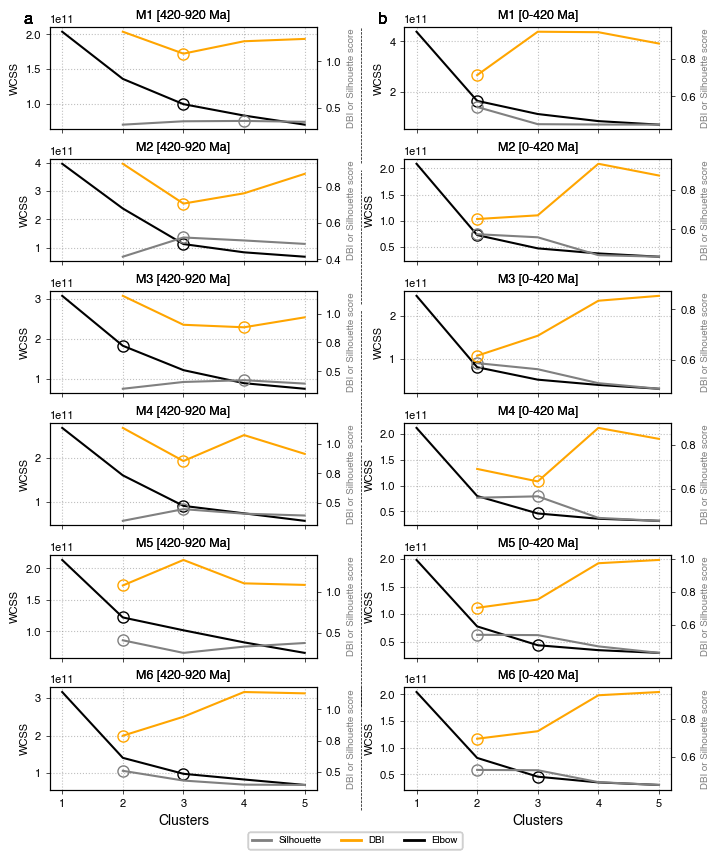

In [64]:

from matplotlib.ticker import StrMethodFormatter
import matplotlib as mpl

# basic settings

mpl.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.weight": "bold",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    "xtick.major.width": 0.5,
    "ytick.major.width": 0.5,
    "xtick.major.size": 3,    # <-- tick length (increase for longer ticks)
    "ytick.major.size": 3,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,
    'ytick.labelsize' :8,
    'xtick.labelsize' :8
})

#-------------------------------Plot DBI, Silhouetted and Elbow scores-----------------------------------#
    
cm = 1/2.54
fig_text = [['a', 'b'], ['c','d'],['e','f'], ['g','h'],['i','j'], ['k','l']]
models_cases =['M1','M2', 'M3', 'M4', 'M5', 'M6']   
elb_x =[[3,2],[3,2],[2,2],[3,3],[2,3],[3,3]]  # elbow bends for considered periods [period1, period2]

# with sns.plotting_context("notebook", font_scale=0.75), sns.axes_style("dark"):
#     sns.set(font="Helvetica", style='whitegrid', rc ={"grid.linestyle": ":","axes.edgecolor": "grey"}, font_scale=0.75) 
fig_elbow, axs = plt.subplots(6, 2, figsize=(18*cm, 21*cm), sharex=True, layout='constrained')   



for j, (model, stats) in enumerate(models_stats.items()):
    k_range = range(1, 6, 1)  # elbow range starting at 1
    dbi_sil_range = range(2, 6, 1)  # DBI and SIL requires two or more clusters 
    

    for i, initial in enumerate(['420-920', '0-420']):
        ax_t = axs[j,i].twinx()
        
        #----------------------------------------- Silhouette plot ------------------------------#
        #sns.lineplot(x=list(dbi_sil_range), y=stats[initial]['silhouette'], color='grey', ax=ax_t)
        ax_t.plot(list(dbi_sil_range), stats[initial]['silhouette'], color='grey')
        sil_maxx, sil_maxy = get_max_point(list(dbi_sil_range), stats[initial]['silhouette'])
        ax_t.plot(sil_maxx, sil_maxy, 'o', markersize=8, markerfacecolor='none', markeredgecolor='grey')

        #----------------------------------------- DBI plot -------------------------------------#
        #sns.lineplot(x=list(dbi_sil_range), y=stats[initial]['dbi'], color='orange', ax=ax_t)
        ax_t.plot(list(dbi_sil_range), stats[initial]['dbi'], color='orange')
        dbi_minx, dbi_miny = get_min_point(list(dbi_sil_range), stats[initial]['dbi'])
        ax_t.plot(dbi_minx, dbi_miny, 'o', markersize=8, markerfacecolor='none', markeredgecolor='orange')

        #-------------------------------------- Elbow plot---------------------------------------#
        #sns.lineplot(x=list(k_range), y=stats[initial]['elbow'], ax=axs[j,i], color='k')
        axs[j,i].plot(list(k_range), stats[initial]['elbow'], color='k')
        elbowx, elbowy = get_y_for_x(list(k_range), stats[initial]['elbow'], elb_x[j][i])
        axs[j,i].plot(elbowx, elbowy, 'o', markersize=8, markerfacecolor='none', markeredgecolor='k')

        axs[j,i].set_xticks(range(1, 6, 1))
        axs[j,i].set_ylabel('WCSS', fontsize=8)
        
        ax_t.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
        ax_t.set_ylabel('DBI or Silhouette score', color='grey', fontsize=7,)
        ax_t.yaxis.grid(False)

        ax_t.set_title(f'{models_cases[j]} [{initial} Ma]', fontsize=9, )
        axs[j,i].set_title(f'{models_cases[j]} [{initial} Ma]', fontsize=9,)
        axs[j,i].grid(True, linestyle=':', color='grey', alpha=0.5)
        if j==5:
            axs[j,i].set_xlabel('Clusters')
            
    # Custom legends
    custom_lines = [
        Line2D([0], [0], color='grey', lw=2, label=f'Silhouette'),
        Line2D([0], [0], color='orange', lw=2, label=f'DBI'),
        Line2D([0], [0], color='k', lw=2, label=f'Elbow'),
    ]
    fig_elbow.legend(handles=custom_lines, ncols=3, loc='center right', fontsize=7, bbox_to_anchor=(0.65, -0.01))
            
      
    # Add vertical line between subplots (midpoint between the axes)
    fig_elbow.subplots_adjust(wspace=0.05)
    fig_elbow.canvas.draw()  # Ensure layout is computed
    bbox0 = axs[j,0].get_position()
    bbox1 = axs[j,1].get_position()
    xline = (bbox0.x1 + bbox1.x0) / 2
    line = Line2D([xline, xline], [bbox0.y0 -0.025, bbox0.y1], transform=fig_elbow.transFigure,
                  color='black', linestyle='--', linewidth=0.5)
    fig_elbow.add_artist(line)
    # Add subplot label (a, b)
    fig_elbow.text(-0.1, 1.15, fig_text[0][0], transform=axs[0,0].transAxes,
                    fontsize=12, fontweight='bold', va='top', ha='left')
    fig_elbow.text(-0.1, 1.15, fig_text[0][1], transform=axs[0,1].transAxes,
                    fontsize=12, fontweight='bold', va='top', ha='left')
#plt.savefig(f'./topologies_recon/Cluster_numbers_comparison_{model}.png', dpi=600)
fig_elbow.savefig('./ExtendedDataFigures/EDF2_Cluster_stats_Elbow_DBI_Silhouette_all_models.pdf', dpi=600,  bbox_inches='tight')
plt.show()

### Figure 3: Spatio-temporal evolution of dynamic topography

In [17]:
def swap_clusters(nc,  rep_a, rep_b, var_to_replace="cluster",):

    if var_to_replace:
    # Extract the variable as a DataArray
        arr = nc[var_to_replace]
        # Step 1: Temporarily mark 0 as 100
        arr = xr.where(np.isfinite(arr) & (arr == rep_a), -1, arr)
    
        # Step 2: Replace 3 with 0
        arr = xr.where(np.isfinite(arr) & (arr == rep_b), rep_a, arr)
    
        # Step 3: Replace temporary 100 (originally 0) with -1
        arr = xr.where(np.isfinite(arr) & (arr == -1), rep_b, arr)
    
        # Return a new dataset with the updated variable
        return nc.assign({var_to_replace: arr})
    else:
        arr=nc
        # Step 1: Temporarily mark 0 as 100
        arr = xr.where(np.isfinite(arr) & (arr == rep_a), -1, arr)
    
        # Step 2: Replace 3 with 0
        arr = xr.where(np.isfinite(arr) & (arr == rep_b), rep_a, arr)
    
        # Step 3: Replace temporary 100 (originally 0) with -1
        arr = xr.where(np.isfinite(arr) & (arr == -1), rep_b, arr)
    
        # Return a new dataset with the updated variable
        return arr

In [18]:
from shapely.geometry import Polygon, MultiPolygon

def explode_only_multipolygons(gdf):
    """
    Explodes only the MultiPolygon geometries in a GeoDataFrame into individual Polygon rows.
    Polygon geometries are left untouched.

    Parameters:
        gdf : GeoDataFrame
            Input GeoDataFrame with Polygon and/or MultiPolygon geometries.

    Returns:
        GeoDataFrame with only Polygon geometries, keeping other data intact.
    """
    exploded_rows = []

    for idx, row in gdf.iterrows():
        geom = row.geometry
        if isinstance(geom, MultiPolygon):
            for part in geom.geoms:
                new_row = row.copy()
                new_row.geometry = part
                exploded_rows.append(new_row)
        else:
            exploded_rows.append(row)

    return gpd.GeoDataFrame(exploded_rows, crs=gdf.crs).reset_index(drop=True)

In [27]:
def swapping_clusters_forplot(dataset, model):

    clusters_ = len([ x for x in np.unique(dataset.cluster) if not(np.isnan(x))])
    #print(clusters_)
    if clusters_ ==2:
            mapping ={
                'gld421' : {0:1},
                'gld428' : {0:1},
                'gld431' : {0:1},
                'gld434' : {0:1},
                'gld486' : {0:1},
                'gld504' : {0:1},
                
            }
            
    else:
        mapping ={
            'gld421' : {0:2, },
            'gld428' : {0:2, 0:1 },
            'gld431' : {0:1, 1:2 },
            'gld434' : {0:2},
            'gld486' : {0:2},
            'gld504' : {0:1,1:2},
            
        }
    mapping_model =mapping[model]
    if mapping_model:
        for rep_a, rep_b in mapping_model.items():
            dataset = swap_clusters(dataset, rep_a, rep_b, var_to_replace='cluster' )
    
        return dataset
    else:
        return dataset
    

In [71]:
import geopandas as gpd
from shapely.validation import make_valid

#cobs= gpd.read_file('./cob_540.shp')
import gplately
from shapely.validation import make_valid

def label_position_reconstruct(row, age):
    
    # model ='gld504'
    # scotese_datapath = r'.././Scotese_paleogeography/Reconstruction/PALEOMAPGlobalPlateModel'

    # scotese_rot_file = f'{scotese_datapath}/PALEOMAP_PlateModel.rot'

    # topology = gplately.pygplates.FeatureCollection(f'{scotese_datapath}/PALEOMAP_PlatePolygons.gpml')
    # static_polyg= gplately.pygplates.FeatureCollection(f'{scotese_datapath}/PALEOMAP_PlatePolygons.gpml')
    
    # model_labelrot = gplately.PlateReconstruction(scotese_rot_file, topology, static_polyg)
    # multipolygon = row['geometry']
    # coordinates = gpd.GeoSeries([multipolygon]).get_coordinates()
    # # point = row.geometry.representative_point()
    # # x, y = point.x, point.y  
    # x = coordinates.x.mean()
    # y = coordinates.y.mean()
    # gpts = gplately.Points(model_labelrot, [x], [y])
    # r_x, r_y = gpts.reconstruct(age, return_array=True)
    # return r_x, r_y
    model ='gld504'
    input_rotation_filenames = [
                f'Reconstructions/For_{model}/1000_0_rotfile_Merdith_et_al_slightly_changed_for_nnr_nico_mod.rot',
                f'Reconstructions/For_{model}/NR_0Ma_1000Ma_for_gplates_combine.rot' 
                                       ]
    topology_features= ['Reconstructions/For_gld504/1000_410_Topologies_Merdith_et_al.gpml']
    #['./Reconstructions/For_gld504/COBfile_1000_0_combined_by_xianzhi.gpml']
    static_polygons =['Reconstructions/shapes_static_polygons_Merdith_et_al.gpml']
    model_labelrot = gplately.PlateReconstruction(input_rotation_filenames, topology_features, static_polygons)
    multipolygon = row['geometry']
    coordinates = gpd.GeoSeries([multipolygon]).get_coordinates()
    # point = row.geometry.representative_point()
    # x, y = point.x, point.y  
    x = coordinates.x.mean()
    y = coordinates.y.mean()
    gpts = gplately.Points(model_labelrot, [x], [y])
    r_x, r_y = gpts.reconstruct(age, return_array=True)
    return r_x, r_y


def topology_merge_label(cobs_path):
    
    def map_plateid(val):
        for k, v in mapping.items():
            if str(val).startswith(k):
                return v
        return None

    mapping ={
        '101':'LAU',
        #'50': 'IN',
        '601':'NCC',
        #'602':'SC',
        '7703' : 'KAL',
        '701' : 'CON',
        '77144' : 'WAC',
        '803':'ANT',
        '802' : 'ANT',
        '206': 'SF',
        '2205': 'SF',
        '8011': 'AUS',
        '201': 'AMZ',
        #'26' :'AN',
        '302': 'BAL',
        '401' :'SIB',
        
        
    }
    cobs= gpd.read_file(cobs_path)
    
    cobs['LABEL'] = cobs['PLATEID1'].apply(lambda x: map_plateid(x) )
    cobs['geometry'] = cobs['geometry'].apply(make_valid)
    dissolved_cobs = cobs.dissolve(by='LABEL').reset_index()
    
    return dissolved_cobs

def merge_by_overlap(gdf, threshold=0.6):
    gdf = gdf.copy()
    
    # Fix invalid geometries
    gdf["geometry"] = gdf.geometry.buffer(0)

    merged = True
    while merged:
        merged = False
        n = len(gdf)
        merged_indices = set()
        merge_groups = []

        for i in range(n):
            if i in merged_indices:
                continue
            group = {i}
            for j in range(i + 1, n):
                if j in merged_indices:
                    continue

                # Catch topology errors safely
                try:
                    inter = gdf.geometry.iloc[i].intersection(gdf.geometry.iloc[j])
                    if inter.is_empty:
                        continue
                    a_i = gdf.geometry.iloc[i].area
                    a_j = gdf.geometry.iloc[j].area
                    if inter.area / a_i >= threshold or inter.area / a_j >= threshold:
                        group.add(j)
                except Exception as e:
                    print(f"Skipping pair ({i},{j}): {e}")
                    continue

            if len(group) > 1:
                merged_indices.update(group)
                merge_groups.append(group)

        if not merge_groups:
            break

        merged = True
        new_geoms = [unary_union([gdf.geometry.iloc[idx] for idx in group]) for group in merge_groups]
        remaining = [gdf.geometry.iloc[i] for i in range(n) if i not in merged_indices]
        gdf = gpd.GeoDataFrame(geometry=new_geoms + remaining, crs=gdf.crs).reset_index(drop=True)

    return gdf
    
# extract only exterior polygon of multipolygon cobs
def extract_outer(gdf_path, group_col):

    gdf = gpd.read_file(gdf_path)
    gdf_proj = gdf.to_crs(epsg=6933)

    largest_polys = []
    for group_val, group_df in gdf_proj.groupby(group_col):
        largest_poly = group_df.loc[group_df.geometry.area.idxmax()]
        largest_polys.append(largest_poly)

    # Return results back in original CRS
    result = gpd.GeoDataFrame(largest_polys, columns=gdf.columns, crs=gdf_proj.crs)
    return result.to_crs(gdf.crs)

m: 0.0 [0. 1.] series:[0, 1, 1]
m: 1.0 [0. 1.] series:[0, 1, 1]
m: 0.0 [0. 1.] series:[0, 1, 1]
m: 1.0 [0. 1.] series:[0, 1, 1]


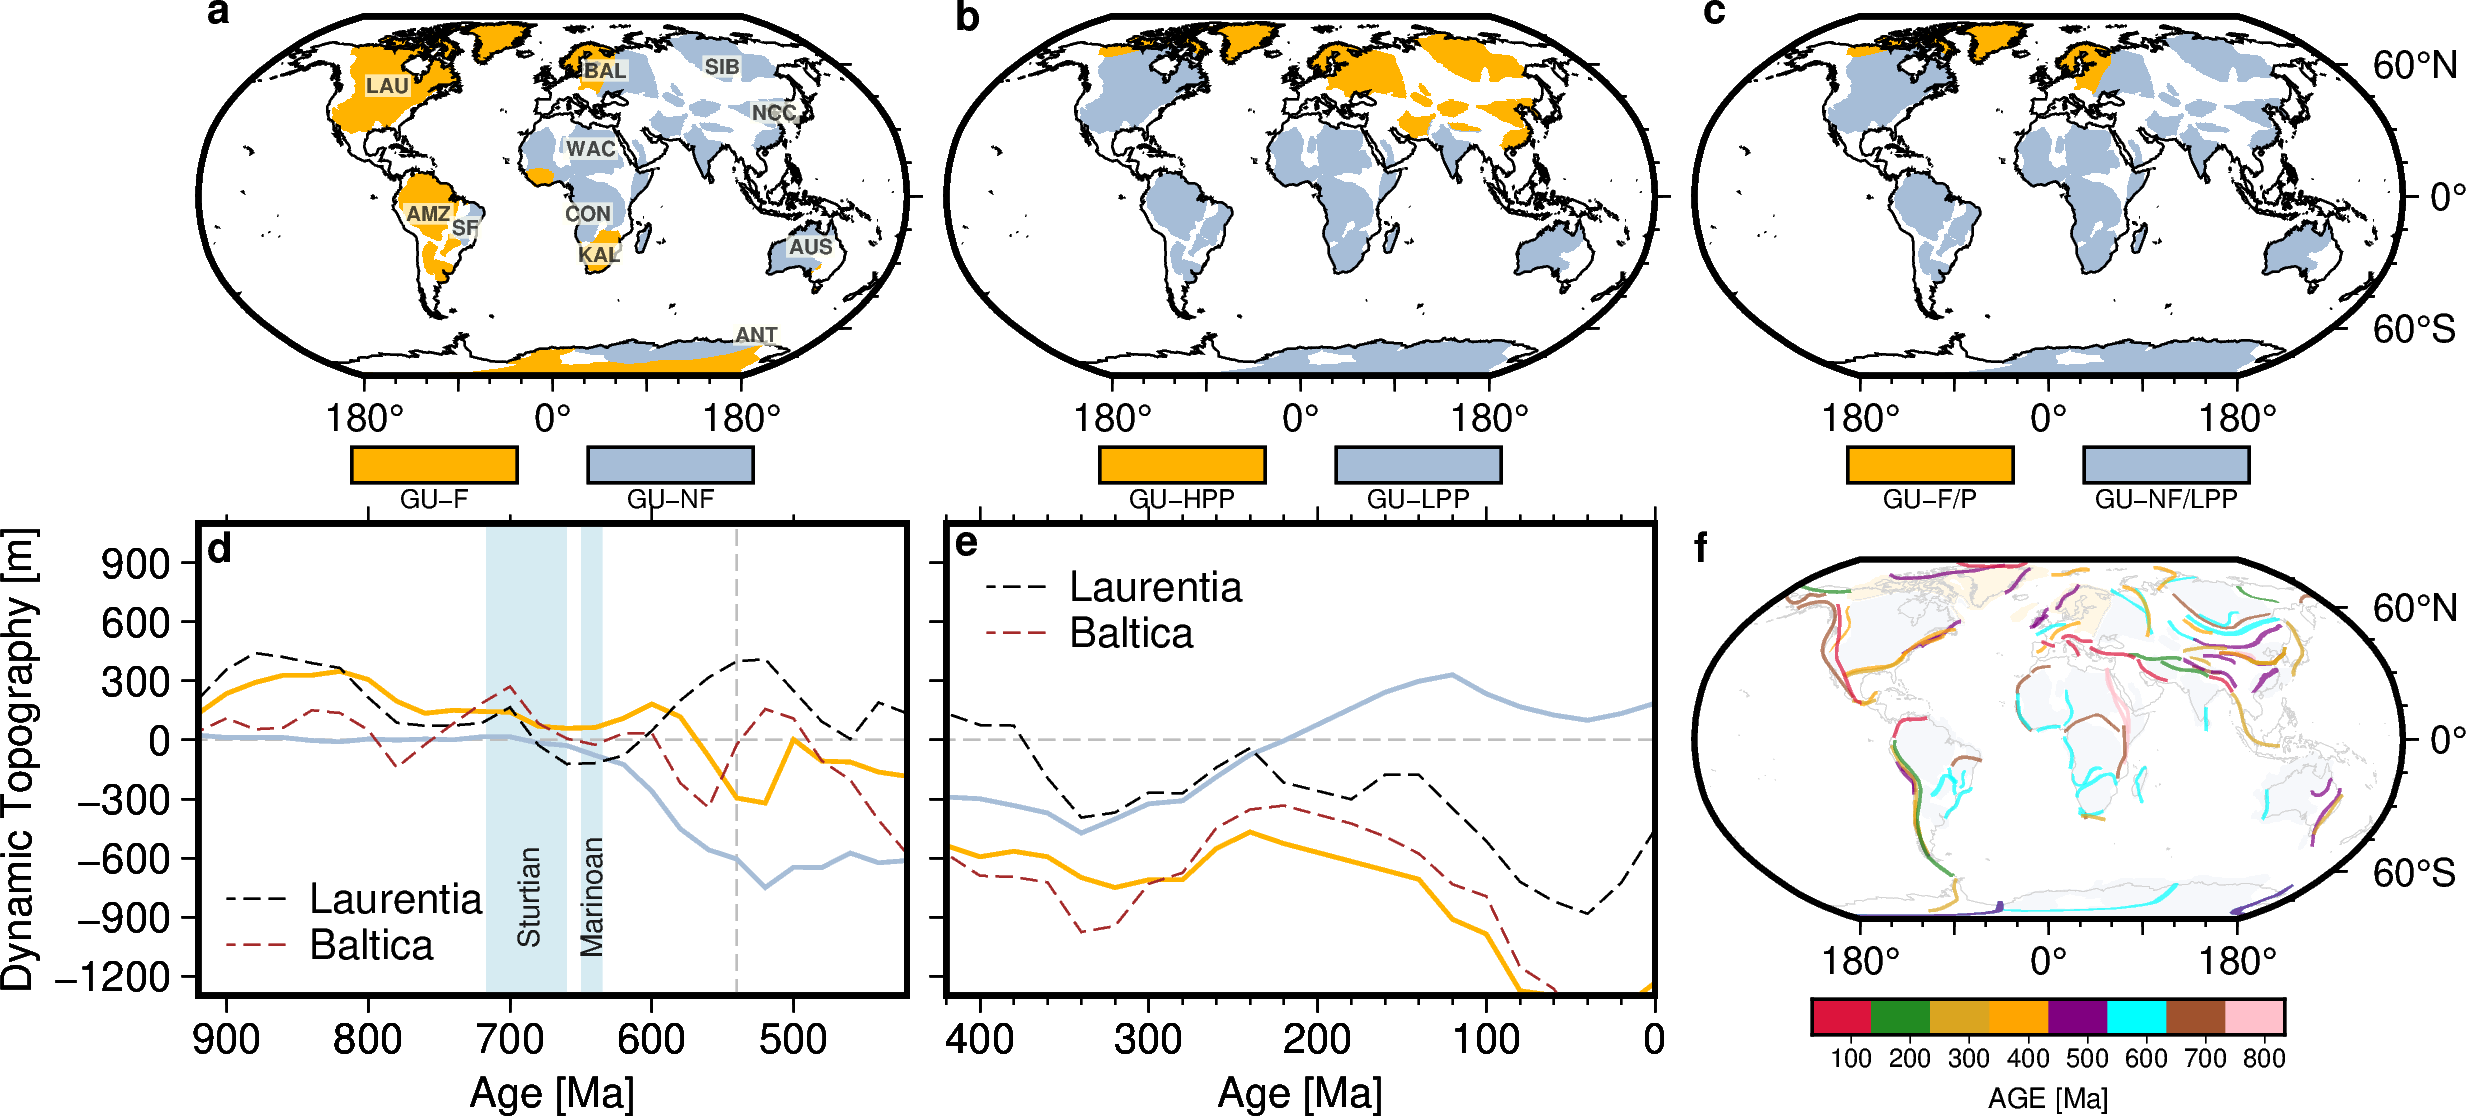

m: 0.0 [0. 1.] series:[0, 1, 1]
m: 1.0 [0. 1.] series:[0, 1, 1]
m: 0.0 [0. 1.] series:[0, 1, 1]
m: 1.0 [0. 1.] series:[0, 1, 1]


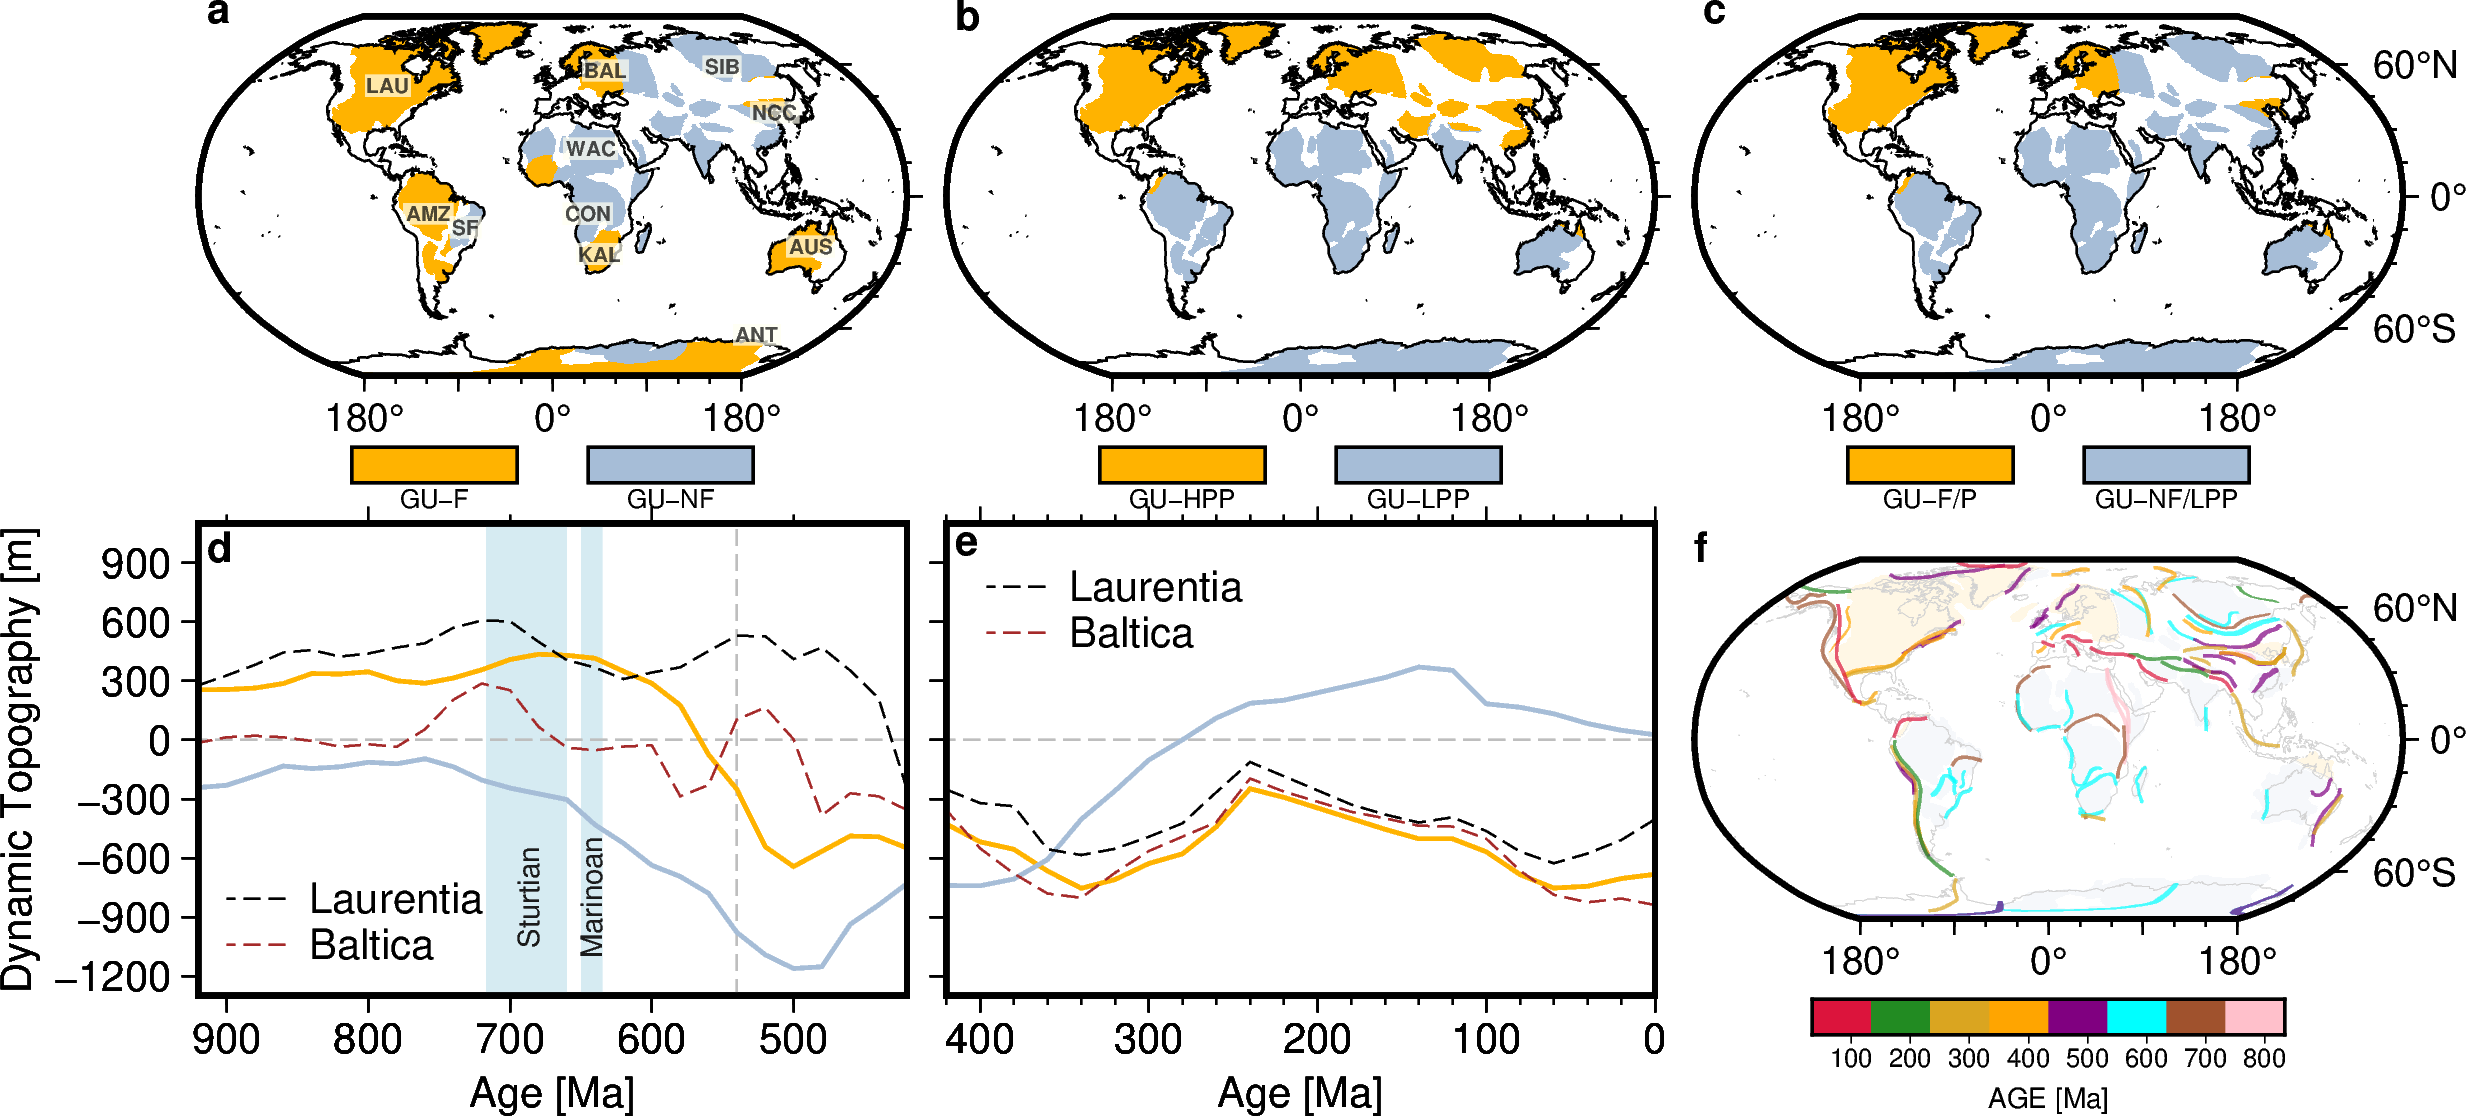

m: 0.0 [0. 1.] series:[0, 1, 1]
m: 1.0 [0. 1.] series:[0, 1, 1]
m: 0.0 [0. 1.] series:[0, 1, 1]
m: 1.0 [0. 1.] series:[0, 1, 1]


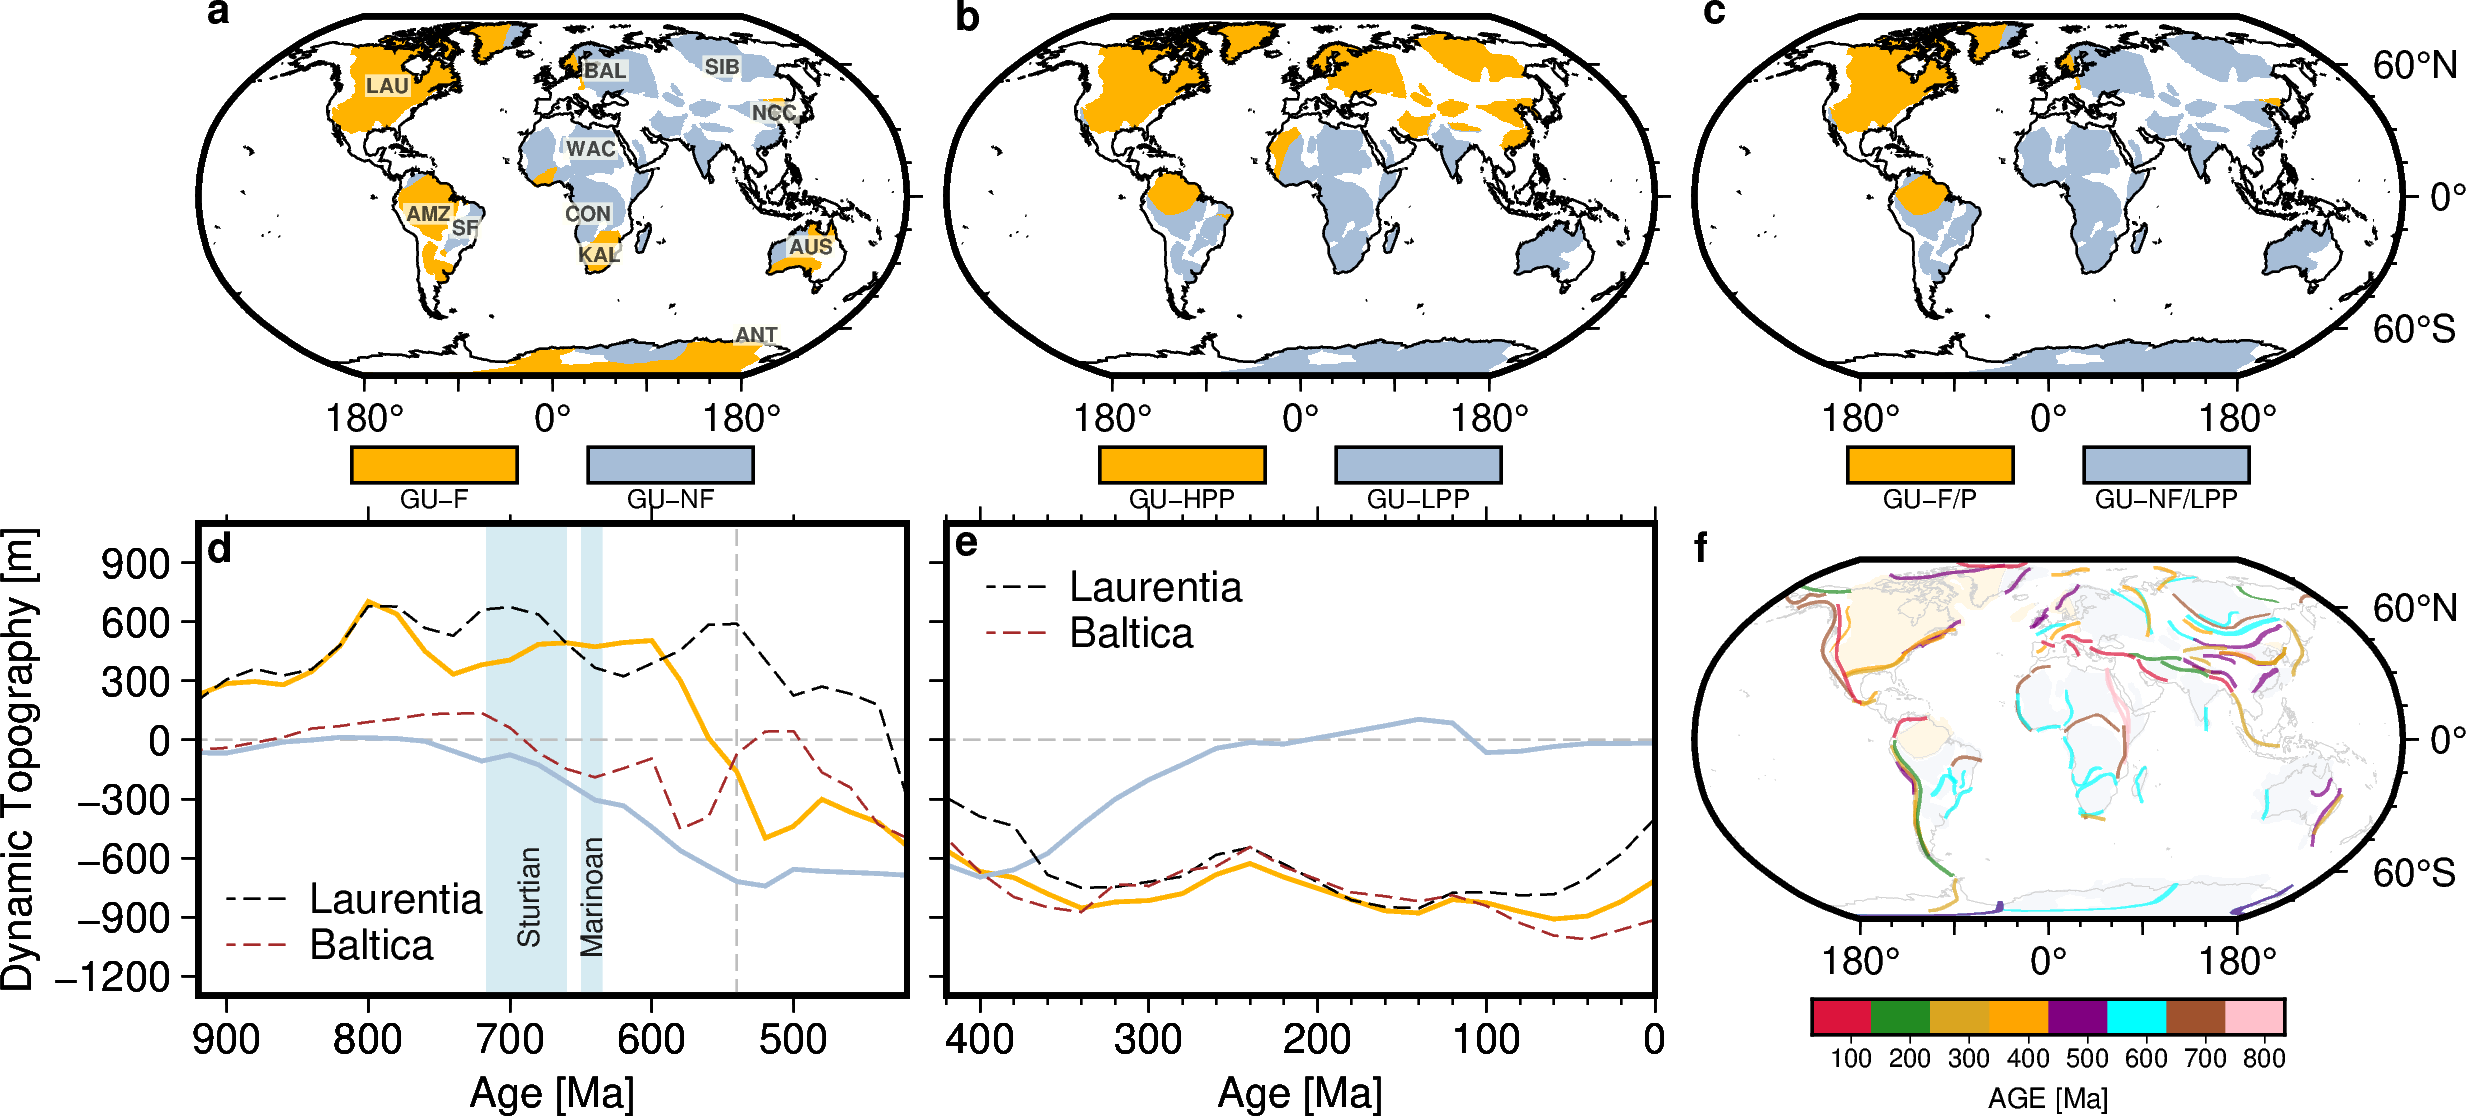

m: 0.0 [0. 1.] series:[0, 1, 1]
m: 1.0 [0. 1.] series:[0, 1, 1]
m: 0.0 [0. 1.] series:[0, 1, 1]
m: 1.0 [0. 1.] series:[0, 1, 1]


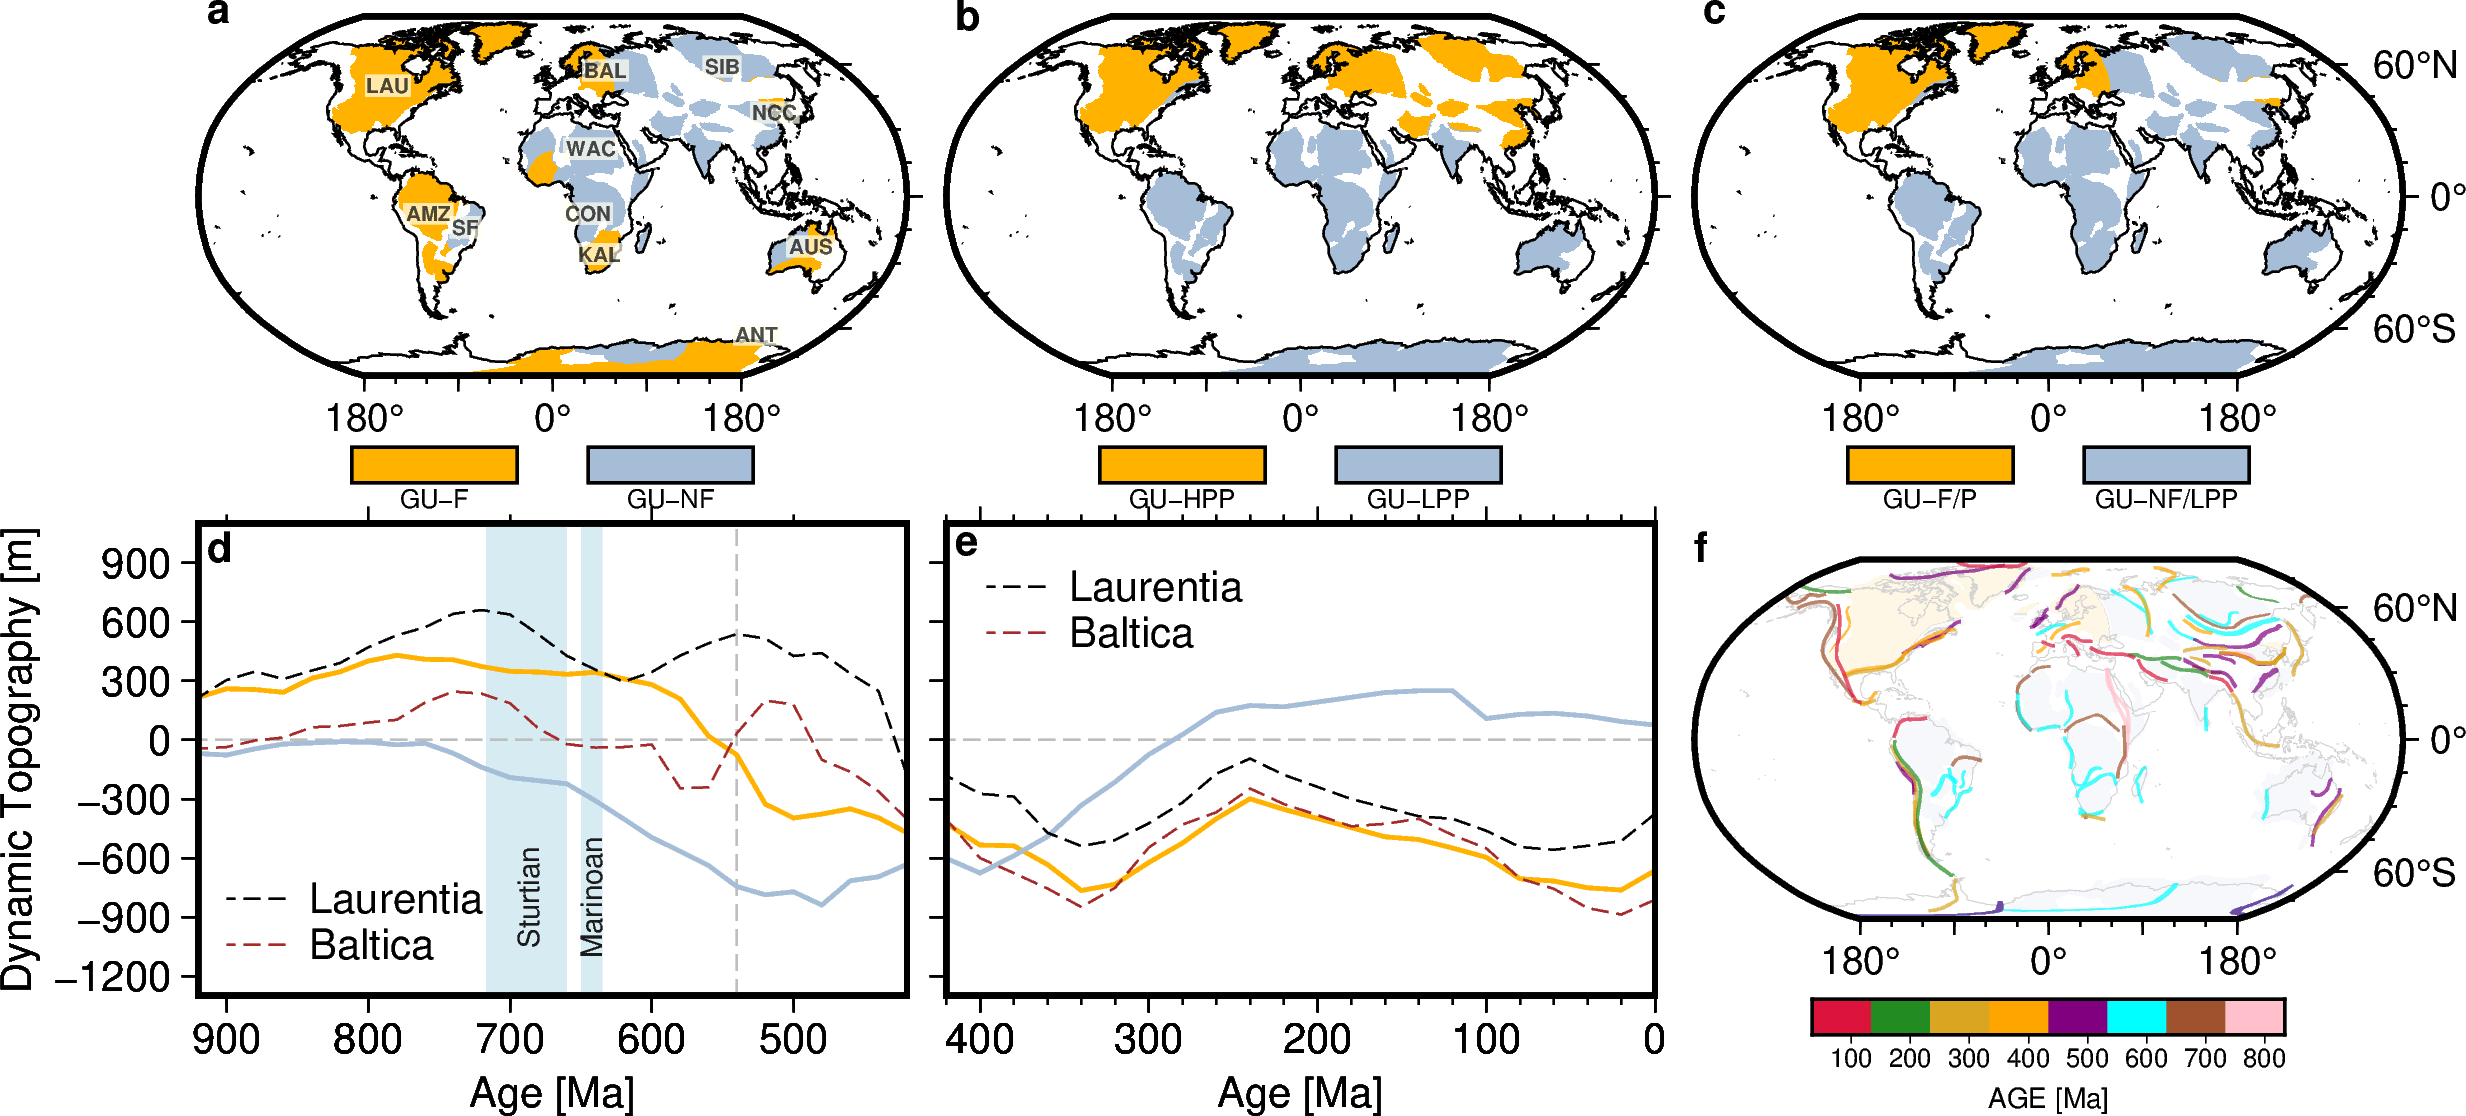

m: 0.0 [0. 1.] series:[0, 1, 1]
m: 1.0 [0. 1.] series:[0, 1, 1]
m: 0.0 [0. 1.] series:[0, 1, 1]
m: 1.0 [0. 1.] series:[0, 1, 1]


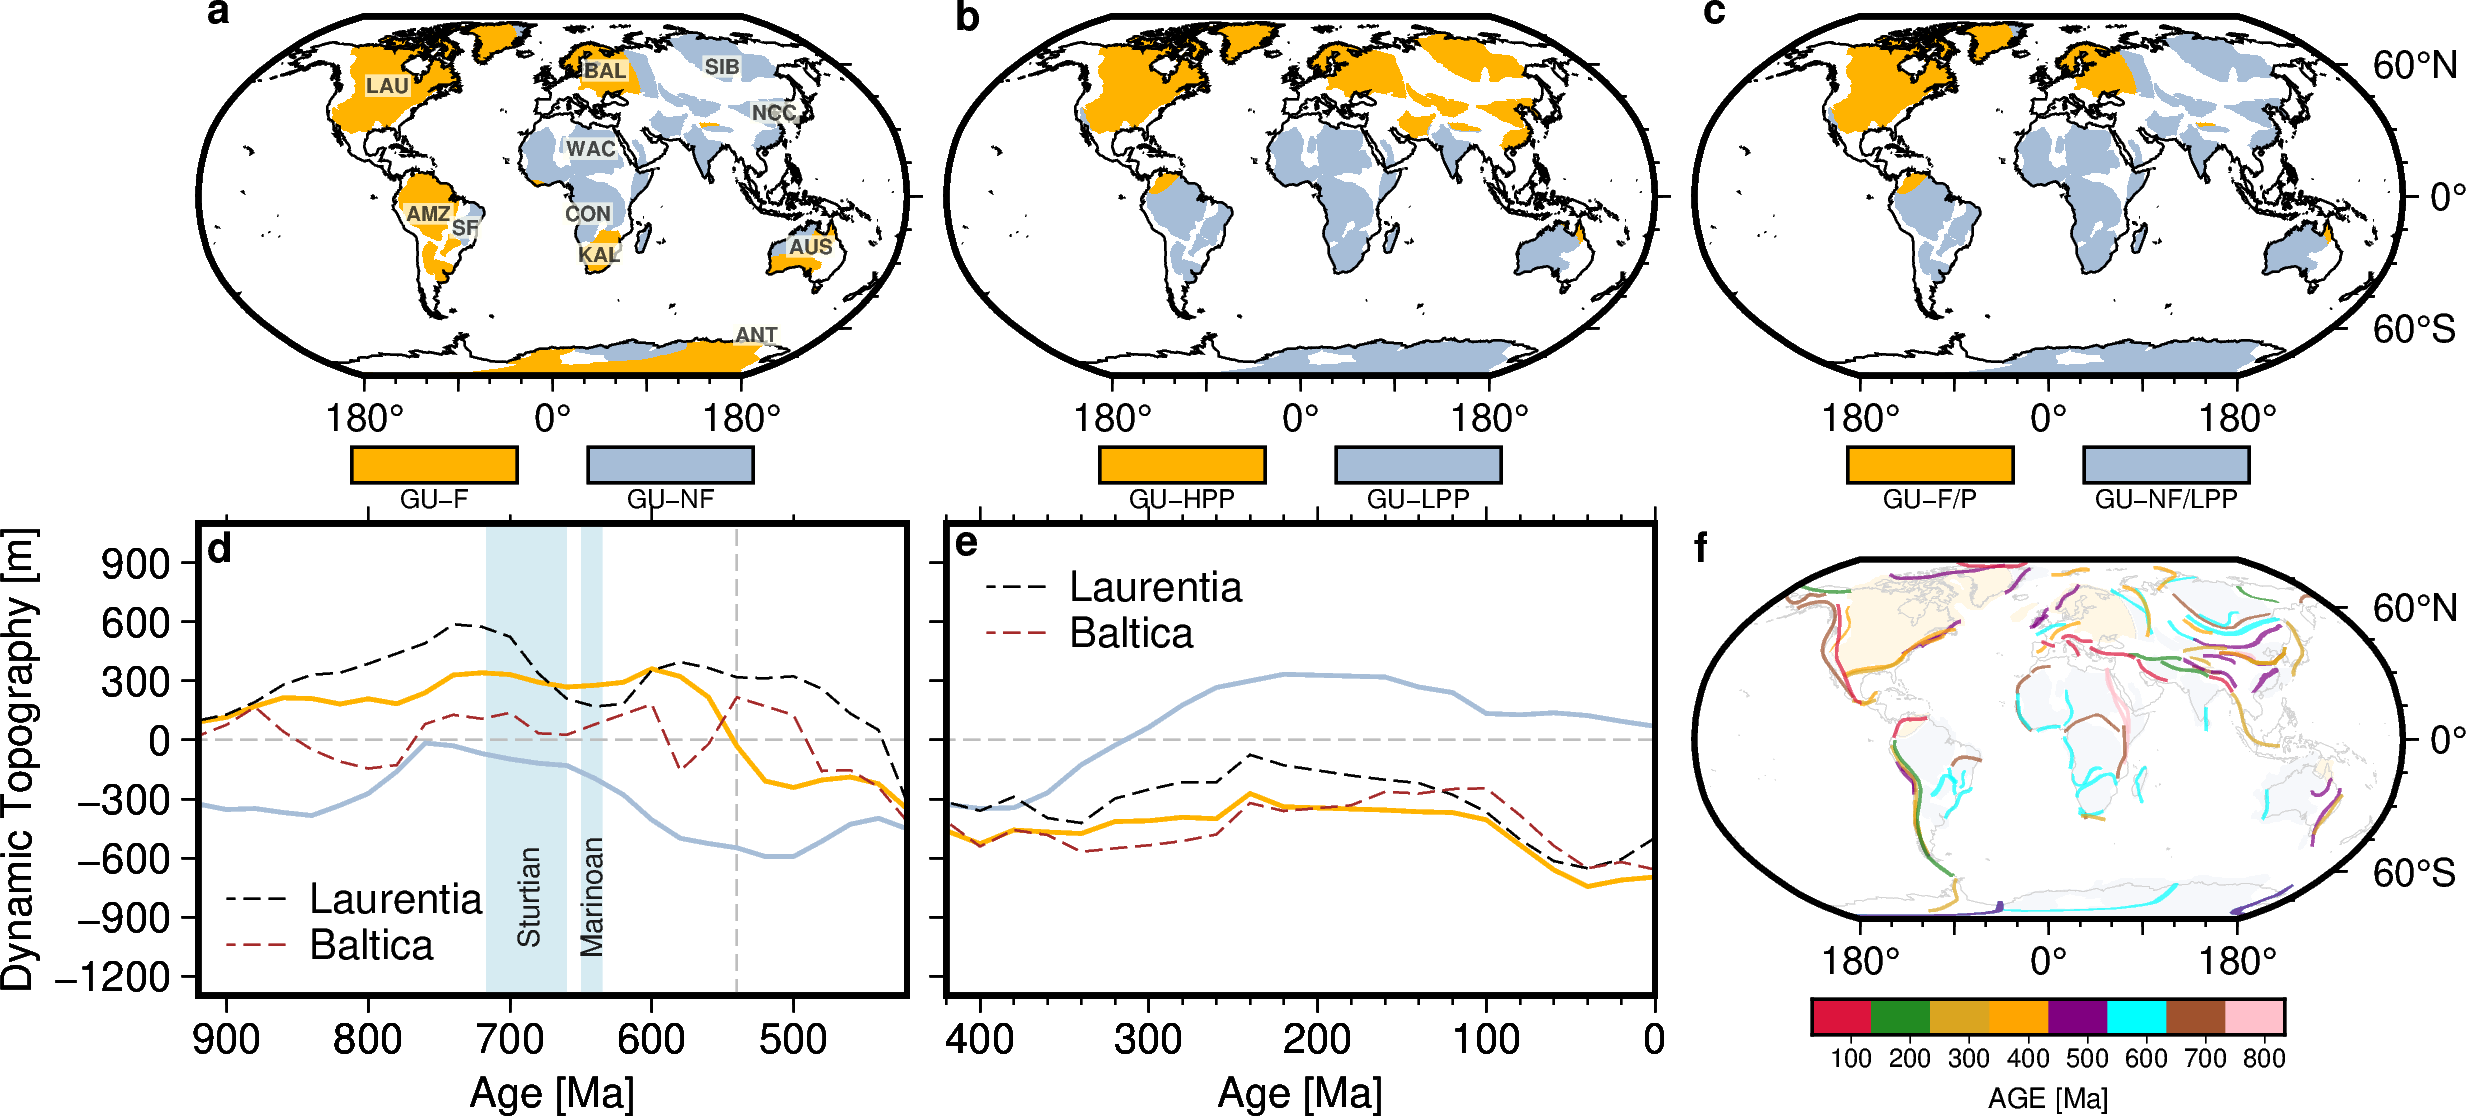

m: 0.0 [0. 1.] series:[0, 1, 1]
m: 1.0 [0. 1.] series:[0, 1, 1]
m: 0.0 [0. 1.] series:[0, 1, 1]
m: 1.0 [0. 1.] series:[0, 1, 1]


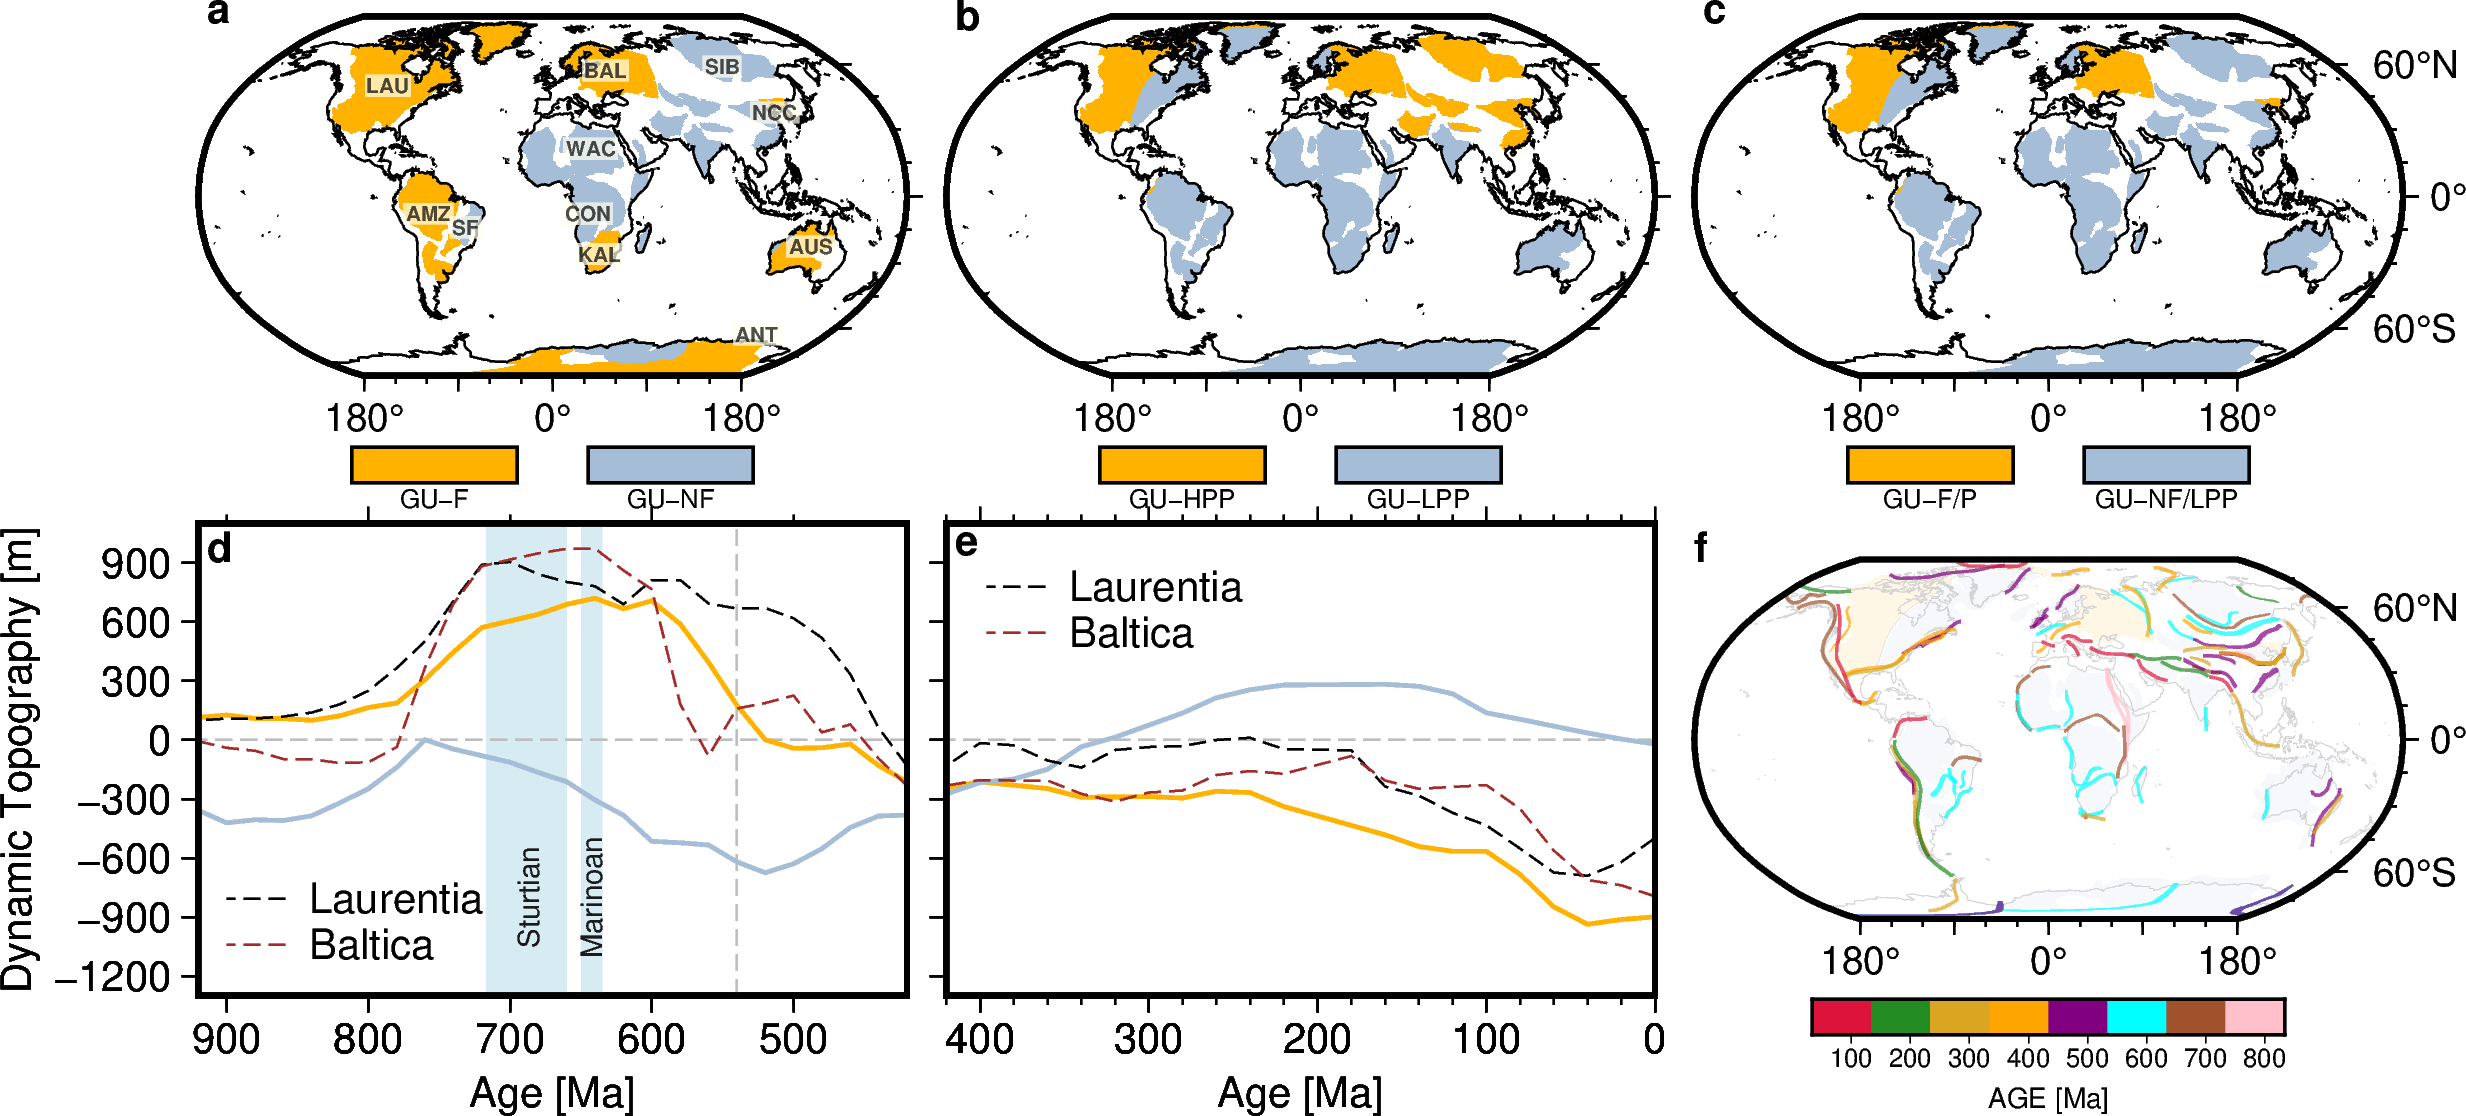

In [72]:
#----------------------------------------------------2 clusters only plot------------------------------------------------------------#
from itertools import zip_longest
import operator
from functools import reduce
import rioxarray
import geopandas as gpd

models =[ 'gld421','gld428', 'gld431', 'gld434', 'gld486', 'gld504']
projection = "N6c"
age=0

pygmt.config(GMT_VERBOSE='q')

for model in models:
    fig = pygmt.Figure()
    loop = [(i, i%2) for i in range(6)]
    pygmt.config(MAP_HEADING_OFFSET="0p", MAP_TITLE_OFFSET="-12p",
                 FONT_TITLE="10p,Helvetica-Bold,black", FONT_HEADING="16p,Helvetica-Bold,black", FONT_TAG="10p, Helvetica-Bold, black",) 

    
    #---------------------------------prepare datasets----------------------------------------#
    age_range=['420-920', '0-420']

    computation_datasets = []
    mapping_datasets =[]
    nc_NA =[]
    nc_BAL=[]
    line_datasets =[]
    line_NA =[]
    line_BAL =[]

    
    for age_ in range(len(age_range)):
        
        cluster_fpath = f'./ClusterAnalysis/cluster_{model}_{age_range[age_]}_2.nc'
        
        NA_nc_fpath = f'./ClusterAnalysis/NA_{model}_{age_range[age_]}.nc'
        BAL_nc_fpath = f'./ClusterAnalysis/BAL_{model}_{age_range[age_]}.nc'
        
        cluster = xr.open_dataset(cluster_fpath)
        # #cluster = nc_preservation
        clusters_ = len([ x for x in np.unique(cluster.cluster) if not(np.isnan(x))])
       
        NA_Nc = xr.open_dataset(NA_nc_fpath)
        BAL_Nc = xr.open_dataset(BAL_nc_fpath)
        computation_datasets.append(cluster)

       #-------------------------------swap clusters for computation of formation and preservation of GU---------------------------------------------------#
        # #--------------------------------mappings---------------------------------------------------------------------#
        
        if clusters_== 2:
            mapping ={
                'gld421' : {0:1},
                'gld428' : {0:1},
                'gld431' : {0:1},
                'gld434' : {0:1},
                'gld486' : {0:1},
                'gld504' : {0:1},
                
            }
            y_glacial=-800
        # if model=='gld421' and age_==1:
        #         mapping_datasets.append(cluster)
        # else:
        mapping_model =mapping[model]
        for rep_a, rep_b in mapping_model.items():
            #print('cluster, repa, repb:',cluster_, rep_a, rep_b)
            
            cluster = swap_clusters(cluster, rep_a, rep_b, var_to_replace='cluster' )
            mapping_datasets.append(cluster)
              
        nc_NA.append(NA_Nc)
        nc_BAL.append(BAL_Nc)
            
        #----------------------------------load cluster swapped dataframes to match color styles------------------------------------#
        df = cluster.to_dataframe().dropna().reset_index().drop(['lat','lon'], axis=1)
        
        df = df.groupby(['cluster','age']).mean('cluster').reset_index()
        df_NA = NA_Nc.mean(dim =['lat','lon']).to_dataframe().reset_index()
        df_BAL = BAL_Nc.mean(dim =['lat','lon']).to_dataframe().reset_index()
        line_datasets.append(df)
        line_NA.append(df_NA)
        line_BAL.append(df_BAL)

    #----------------------Elementwise multiplication of formation nc and preservation nc----------------------------#
    nc_preservation = reduce(operator.mul, computation_datasets).cluster
    nc_pres= nc_preservation.to_dataset(name='cluster')
    nc_pres = swap_clusters(nc_pres, 0, 1, var_to_replace='cluster' )
    datasets =mapping_datasets+ [nc_pres] +line_datasets +[nc_pres]
    
    cmaps = ["#FFB300,#A6BDD7","#FFB300,#A6BDD7", "#FFB300,#A6BDD7","#FFB300,#A6BDD7","#FFB300,#A6BDD7", "#A6BDD7,FFB300",]
    color_models= ["+cGU-F,GU-NF", "+cGU-HPP,GU-LPP", "+cGU-F/P,GU-NF/LPP","+cGU-F,GU-NF", "+cGU-HPP,GU-HPP", "+cGU-HPP,GU-LPP"]
   

    #-------------------------------Loop through datasets and plot------------------------------------------------#
    for j, k  in loop: #[(0,0),(1,1),(2,0),(3,1)]:
        #print(i)

        if j==3:
            axis_pos ='WrtS'
            i=0
            position ="JBL+jBL+o0.1c+w3c"
        else:
            axis_pos ='rwtS'
            i=1
            position ="JTL+jTL+o0.2c+w3c"
        
        with fig.subplot(nrows=2, ncols=3, figsize=("19c", "8c"), frame="lrtb", margins=["0p", "0p"],
            sharex="b", sharey="r", autolabel='a',):
            
        
            #--------------------------------Cluster Plots--------------------------------------#
            if j <3:
                with fig.set_panel(panel=j, clearance=['n-0.75c','s1.25c']): 

                    #cluster = nc_preservation
                    nclusters_ = len([ x for x in np.unique(datasets[j].cluster) if not(np.isnan(x))])
                    series_cl = [0, nclusters_ -1, 1]
                    pygmt.makecpt(cmap=cmaps[j], series=series_cl, color_model= color_models[j] )
                    

                    # #-------------------------------swap clusters only for plotting---------------------------------------------------#
                    # cluster_swapped =swapping_clusters_forplot(datasets[j], model)
                    land_mask_file = glob.glob('./orogens/ne*/*shp')
                    land_mask = gpd.read_file(land_mask_file[0])
                    
                    datasets[j]=datasets[j].rio.write_crs("epsg:4326", inplace=True).rename({'lon':'x', 'lat':'y'})
                    masked_dataset=datasets[j].rio.clip(geometries=land_mask.geometry, crs=4326, all_touched=True)

                    fig.grdimage(grid=masked_dataset.cluster, projection=projection, region= 'd', nan_transparent="+znan",  cmap=True , frame=None)
                    fig.coast(shorelines="1/0.5p", region='d', projection=projection    )
                    
                    
                    fig.basemap(region='d', projection=projection, frame= ["etlS",f"xaf", "yaf"])
                
                    with pygmt.config(FONT_ANNOT_PRIMARY='12p'):
                        fig.colorbar(cmap=True, position="x3c/-0.75c+w4c/0.3c+jTC+h+e+ml")

                    if j==0:
                        #add continent labels
                        
                        cobs_path = f'./topologies_reconstructed/gld504/gld504_reconstructed_COB_0.shp'
                        COBS = topology_merge_label(cobs_path )
                        for _, row in COBS.iterrows():
                            # Get a point that is guaranteed to be inside the polygon
                            
                            r_x, r_y = label_position_reconstruct(row,0)
                            label = row["LABEL"] # or any label field you want
                            if label=='ANT':
                                r_x = r_x -20
                                r_y= r_y+5
                            #fig.text(x=x, y=y, text=label, font="3p,Helvetica,black, bold", justify="CM", region=region, projection=projection)
                            fig.text(x=r_x, y=r_y, text=label, font="5p,Helvetica-Bold,black",fill='ivory', transparency=30, justify="CM", region='d', projection=projection, verbose='q')
            
                
            #-------------------------------------------Line Plots for each cluster--------------------------------------------------#    

            elif j<5:
                with fig.set_panel(panel=j,):
               
            
                    pygmt.config(FONT_ANNOT_PRIMARY ='10p, Helvetica, Black', FONT_LABEL ='10p, Helvetica, Black', FONT_ANNOT = '10p, Helvetica, Black')

                    nclusters_ = len(np.unique(datasets[j].cluster))
                    series_cl =[0, nclusters_ -1,1]
                    pygmt.makecpt(cmap=cmaps[j], series=series_cl, color_model= color_models[j])
                        
                    df=line_datasets[i]
                    df_NA = line_NA[i]
                    df_BAL = line_BAL[i]
                
                    region_cl = [min(df.age), max(df.age), -1300,1100]
                    
                    proj_cl="X-6c/4c"
                
                    # Sturtian Glacian period
                    y_=[-1300,-1300,1300,1300,1300]
                    fig.basemap(region=region_cl, projection=proj_cl, frame= ["nS",f"xaf", "yaf"])
                    fig.plot(
                        x=[717, 660, 660, 717, 717],
                        y=y_, #[df.z.min(), df.z.min(), df_NA.z.max(), df_NA.z.max(), df_NA.z.max()],
                        fill="lightblue",
                        projection = proj_cl,
                        transparency=50
                    )
                    fig.text(
                        text="Sturtian",
                        x=(730+660)/2,  # Midpoint of 700 and 635
                        y= y_glacial, #(df.z.min() +df.z.max())/2,  # Center of the vertical space
                        angle=90,  # Rotate text vertically
                        font="7p,grey10",
                        justify="TC",
                        projection = proj_cl,
                    )
                    
                    # Maronian Glaciation Period
                  
                    fig.plot(
                        x=[650, 635, 635, 650, 650],
                        y=y_, #[df.z.min(), df.z.min(), max(df_NA.z.max(), df.z.max()), max(df_NA.z.max(), df.z.max()), max(df_NA.z.max(), df.z.max())],
                        fill="lightblue",
                        transparency=50,
                        projection = proj_cl,
                    )
                    
                    fig.text(
                        text="Marinoan",
                        x= (665+650)/2,  # Midpoint of 700 and 635
                        y=  y_glacial, #(df.z.min() +df.z.max())/2,  # Center of the vertical space
                        angle=90,  # Rotate text vertically
                        font="7p,grey10",
                        justify="MC"
                    )
                     
                    #fig.plot(x=[540]*len(df.z), y=np.linspace(df.z.min(), df_NA.z.max(), len(df.z)), region=region_cl, projection = proj_cl, pen='0.5p,grey, --')
                    fig.plot(x=[540]*len(df.z), y=np.linspace(-1300,1100, len(df.z)), region=region_cl, projection = proj_cl, pen='0.5p,grey, --')
                    fig.plot(x=df_NA.age, y=[0]*df_NA.z, region=region_cl, projection = proj_cl, pen='0.5p,grey, --')
                    #fig.plot(x=df_BAL.age, y=[0]*df_BAL.z, region=region_cl, projection = proj_cl, pen='0.5p,grey, --')
                    
                    for m in np.unique(df.cluster):
                        df_selected = df[df.cluster==m]
                        df_outlier = df_selected[df_selected['age']==180.0]
                        df_trimmed=df_selected[~df_selected['age'].isin([180])]
                        
                        #print(df_outlier)
                        # For presentation
                        #fig.plot(x=df_trimmed.age, y=df_trimmed.z, region=region_cl, projection = proj_cl, zvalue=m, pen='1p,+z', cmap=True, frame =[f'{axis_pos}', "xa100+lAge [Ma]", "ya300+lDynamic Topography [m]",])
                        
                        fig.plot(x=df_trimmed.age, y=df_trimmed.z, region=region_cl, projection = proj_cl, zvalue=m, pen='1p,+z', cmap=True, frame =False)

                        #fig.plot(x=df_outlier["age"], y=df_outlier["z"], region =region_cl, projection= proj_cl, zvalue=i,style="t0.2c", pen='0.5p,+z', cmap=True)
                        print(f'm:',m, np.unique(df.cluster), f'series:{series_cl}')
                    fig.plot(x=df_NA.age, y=df_NA.z, region=region_cl, projection = proj_cl, pen='0.5p,black, --', label ='Laurentia', frame =[f'{axis_pos}', "xa100+lAge [Ma]", "ya300+lDynamic Topography [m]",])
                    fig.plot(x=df_BAL.age, y=df_BAL.z, region=region_cl, projection = proj_cl, pen='0.5p,brown, --', label ='Baltica', frame =[f'{axis_pos}', "xa100+lAge [Ma]", "ya300+lDynamic Topography [m]",])
                    fig.legend(position =position)
                    
            
            else:
                orogens_fpath = glob.glob('./orogens/Orogens_shps/Oro*.shp')
                orogens = gpd.read_file(orogens_fpath[0])
                orogens = orogens[orogens['FROMAGE'] <=900].sort_values(by='FROMAGE', ascending=False)
                with fig.set_panel(panel=j, clearance= ['s0.65c']):
                    #olors_10 = ['#FF6F61,#6B5B95,#88B04B,#F7CAC9,#92A8D1,#955251,#B565A7,#009B77,#DD4124,#45B8AC']
                    colors_10  = ['#DC143C,#228B22,#0000CD,#DAA520,#FFA500,#800080,#00FFFF,#FFC0CB,#A0522D,pink']
                    pygmt.makecpt(cmap="#FFB300,#A6BDD7", series=[0,1], continuous=False)              
                    fig.grdimage(grid=nc_pres.cluster, projection=projection, region= 'd', nan_transparent="+znan",  cmap=True , frame=None, transparency=90)
                    fig.coast(shorelines="1/0.01p, lightgrey", region='d', projection=projection    )
                
                    pygmt.makecpt(cmap=colors_10, series=[orogens['ONSET_DEFO'].min(),orogens['ONSET_DEFO'].max(),100])
                    
                    fig.plot(data=orogens, fill="+z", a="Z=FROMAGE", cmap=True, projection=projection, transparency=30)
                    
                        
                    fig.basemap(region='d', projection=projection, frame= ["EtlS",f"xaf", "yaf"])
                    fig.text(
                        text="f",
                        font = '10p, Helvetica-Bold, black',
                        position="TL",# Top Left
                        offset="-0.c/0.c",
                        no_clip =True
                    )
                    
                    with pygmt.config(FONT_ANNOT_PRIMARY='12p'):
                        fig.colorbar(position="x3c/-0.75c+w4c/0.3c+jTC+h", frame='a100f+lAGE [Ma]')

                    
                
    
                if model=='gld504':
                    fig.savefig(f'./MainFigures/Figure3-{model}_GU_formation_preservation_orogens_2clusters.pdf',resize='+s18.2c', dpi=600)
                fig.show()

    

### Sensitivity to number of clusters [2,3] and votemaps to cluster combinations

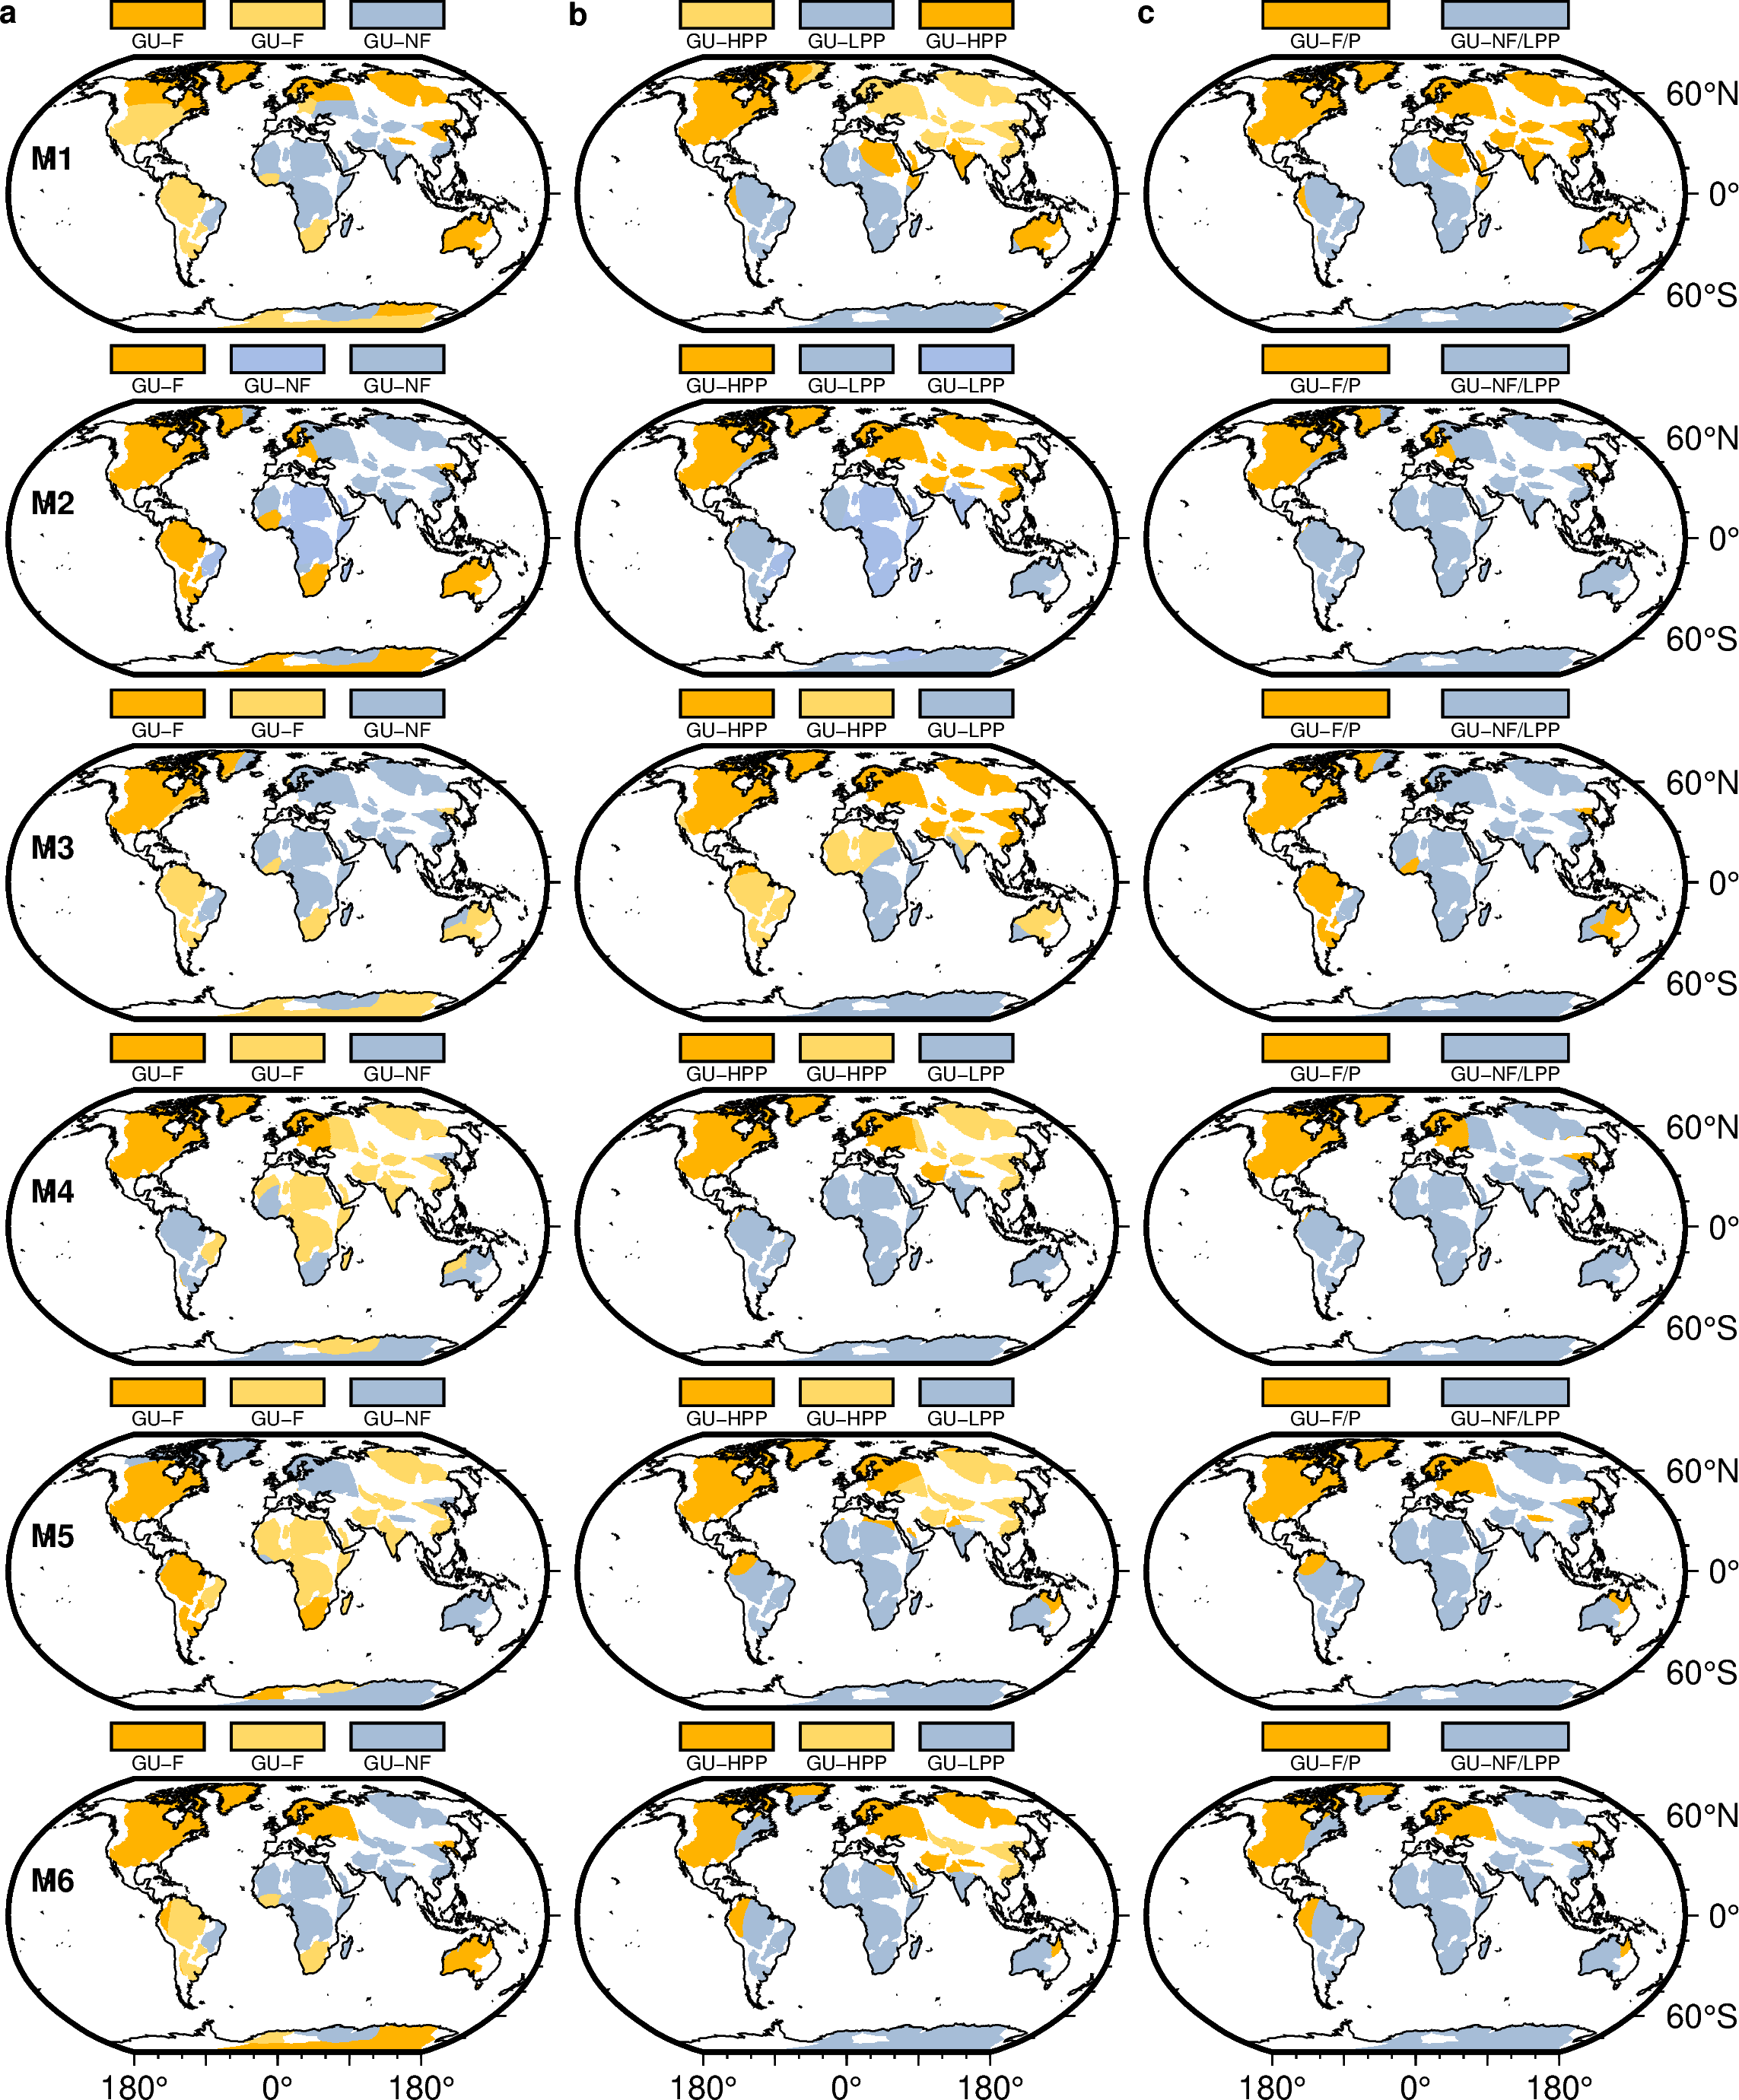

In [66]:
#2-2 mapping for each model
import operator
from functools import reduce

def change_clusters_for_computation(nc, model, age):
    clusters_ = len([ x for x in np.unique(nc.cluster) if not(np.isnan(x))])
    if clusters_==2:
        return nc
    else:
        if age =='420-920':
            
           if model =='gld421':
               nc = nc.where((nc==1) | nc.isnull(), 1)
           elif  model =='gld428':
               nc = nc.where((nc<2) | nc.isnull(), 0)
           else:
               nc = nc.where((nc<2) | nc.isnull(), 1)
    
        else:
            if (model =='gld421') | (model=='gld431') :
                nc = nc.where((nc>0) | nc.isnull(), 1)
                nc = nc.where((nc<2)  | nc.isnull(), 0)
            elif model =='gld428':
                nc = nc.where((nc<2) | nc.isnull(),0)
            else:
                nc = nc.where((nc<2) | nc.isnull(), 1)
    
        return nc

# for plotting
def swapping_clusters_forplot(dataset, model, age):

    clusters_ = len([ x for x in np.unique(dataset.cluster) if not(np.isnan(x))])
    #print(clusters_)
    if clusters_ ==2:
        # cmap = "#FFB300,#A6BDD7"
        # color_model= "+cGU-F,GU-NF"
        if age == '420-920':
            mapping ={
                'gld421' : {0:1},
                'gld428' : {0:1},
                'gld431' : {0:1},
                'gld434' : {0:1},
                'gld486' : {0:1},
                'gld504' : {0:1},
                
            }
            color_model= {
                'gld421' : "+cGU-F,GU-NF",
                'gld428' : "+cGU-F,GU-NF",
                'gld431' : "+cGU-F,GU-NF",
                'gld434' : "+cGU-F,GU-NF",
                'gld486' : "+cGU-F,GU-NF",
                'gld504' : "+cGU-F,GU-NF",
                
            }
            cmap= {
                'gld421' : '#FFB300,#A6BDD7',
                'gld428' : '#FFB300,#A6BDD7',
                'gld431' : '#FFB300,#A6BDD7',
                'gld434' : '#FFB300,#A6BDD7',
                'gld486' : '#FFB300,#A6BDD7',
                'gld504' : '#FFB300,#A6BDD7', 
                }
        else:
            mapping ={
                'gld421' : {0:1},
                'gld428' : {0:1},
                'gld431' : {0:1},
                'gld434' : {0:1},
                'gld486' : {0:1},
                'gld504' : {0:1},
                
            }
            color_model= {
                'gld421' : "+cGU-HPP,GU-LPP",
                'gld428' :  "+cGU-HPP,GU-LPP",
                'gld431' :  "+cGU-HPP,GU-LPP",
                'gld434' :  "+cGU-HPP,GU-LPP",
                'gld486' :  "+cGU-HPP,GU-LPP",
                'gld504' :  "+cGU-HPP,GU-LPP",
                
            }
            cmap= {
                'gld421' : '#FFB300,#A6BDD7',
                'gld428' : '#FFB300,#A6BDD7',
                'gld431' : '#FFB300,#A6BDD7',
                'gld434' : '#FFB300,#A6BDD7',
                'gld486' : '#FFB300,#A6BDD7',
                'gld504' : '#FFB300,#A6BDD7', 
                }
        
    else:
        
        if age == '420-920':
            mapping ={
                'gld421' : {0:2, },
                'gld428' : {0:2, 0:1 },
                'gld431' : {0:1, 1:2 },
                'gld434' : { 0:2, 0:1},
                'gld486' : { 0:2, 0:1},
                'gld504' : {0:1,1:2},
                
            }
            
            color_model= {
                'gld421' : "+cGU-F,GU-F,GU-NF",
                'gld428' : "+cGU-F,GU-NF,GU-NF",
                'gld431' : "+cGU-F,GU-F,GU-NF",
                'gld434' : "+cGU-F,GU-F,GU-NF",
                'gld486' : "+cGU-F,GU-F,GU-NF",
                'gld504' : "+cGU-F,GU-F,GU-NF",
                
            }
            cmap= {
            'gld421' : '#FFB300,#FFD966,#A6BDD7',
            'gld428' : '#FFB300,#A6BDE7,#A6BDD7',
            'gld431' : '#FFB300,#FFD966,#A6BDD7',
            'gld434' : '#FFB300,#FFD966,#A6BDD7',
            'gld486' : '#FFB300,#FFD966,#A6BDD7',
            'gld504' : '#FFB300,#FFD966,#A6BDD7', 
            
            }
            
            
        else:
            
            mapping ={
                'gld421' : {0:1, 1:2},
                #'gld421' : { 1:2},
                'gld428' : {0:1, 1:2},
                'gld431' : {0:1, },
                'gld434' : { 0:2},
                'gld486' : { 0:2},
                'gld504' : {0:1, 1:2,},
                
            }
            #cmap= "gmt/cyclic"
            color_model= {
                'gld421' : "+cGU-HPP,GU-LPP,GU-HPP",
                'gld428' : "+cGU-HPP,GU-LPP,GU-LPP",
                'gld431' : "+cGU-HPP,GU-HPP,GU-LPP",
                'gld434' : "+cGU-HPP,GU-HPP,GU-LPP",
                'gld486' : "+cGU-HPP,GU-HPP,GU-LPP",
                'gld504' : "+cGU-HPP,GU-HPP,GU-LPP",
                
            }
            cmap= {
            'gld421' : '#FFD966,#A6BDD7,#FFB300',
            'gld428' : '#FFB300,#A6BDD7,#A6BDE7',
            'gld431' : '#FFB300,#FFD966,#A6BDD7',
            'gld434' : '#FFB300,#FFD966,#A6BDD7',
            'gld486' : '#FFB300,#FFD966,#A6BDD7',
            'gld504' : '#FFB300,#FFD966,#A6BDD7',
                
            }
           
            
        
            
    mapping_model =mapping[model]
    if mapping_model:
        for rep_a, rep_b in mapping_model.items():
            #print(f'model:{model}, {rep_a}, {rep_b}, {age_}')
            dataset = swap_clusters(dataset, rep_a, rep_b, var_to_replace='cluster' )
    
        return dataset, cmap[model], color_model[model]
    else:
        return dataset, cmap[model], color_model[model]

        

models =[ 'gld421','gld428', 'gld431', 'gld434', 'gld486', 'gld504']
model_labels =['M1', 'M2', 'M3', 'M4', 'M5', 'M6']
projection = "N6c"
age=0
nclusters_full =[[2,2], [2,3], [3,2], [3,3]]
cluster_combination_final_binary = {}


for nclusters in nclusters_full:

    if nclusters==[2,2]:
        figsize=("19c", "20c")
        titles =['Formation','Preservation','Combined']
    else:
        titles =['','','']
        figsize=("19c", "23c")

    fig = pygmt.Figure()
     
    
    nc_formation_preservation =[]
    with fig.subplot(nrows=6, ncols=3, figsize=figsize, frame="lrtb", margins=["0p", "0p"],
            sharex="b", sharey="r", autolabel=False):
    
        for m, model in enumerate(models):
            
            #loop = [(i, i%2) for i in range(6)]
            pygmt.config(MAP_HEADING_OFFSET="0p", MAP_TITLE_OFFSET="-12p",
                         FONT_TITLE="10p,Helvetica-Bold,black", FONT_HEADING="16p,Helvetica-Bold,black", FONT_TAG="10p, Helvetica-Bold, black",) 
        
            
            #---------------------------------prepare datasets----------------------------------------#
            age_range=['420-920', '0-420']
        
            computation_datasets = []
            mapping_datasets =[]
            cmaps =[]
            color_models=[]
            
            for k, age_ in enumerate(age_range):
                
                cluster_fpath = f'ClusterAnalysis/cluster_{model}_{age_}_{nclusters[k]}.nc'
                cluster = xr.open_dataset(cluster_fpath)
                mapping_cluster= cluster.copy()
                
                computation_datasets.append(change_clusters_for_computation(cluster, model, age_))
                mapped_cluster, cm, color_mod = swapping_clusters_forplot(mapping_cluster, model, age_)
                mapping_datasets.append(mapped_cluster)
                cmaps.append(cm)
                color_models.append(color_mod)
                
        
            #----------------------Elementwise multiplication of formation nc and preservation nc----------------------------#
            nc_preservation = reduce(operator.mul, computation_datasets).cluster
            nc_pres= nc_preservation.to_dataset(name='cluster')
            nc_pres = swap_clusters(nc_pres, 0, 1, var_to_replace='cluster' )
    
            nc_formation_preservation.append(nc_pres)
            nc_pres_color_map =['#FFB300,#A6BDD7']
            nc_pres_color_model =['+cGU-F/P,GU-NF/LPP']
            
            datasets =mapping_datasets+ [nc_pres] 
            cmaps = cmaps+nc_pres_color_map
            color_models =color_models+nc_pres_color_model
    
    
            for j in range(len(datasets)):

                
            
                #--------------------------------Cluster Plots--------------------------------------#
               
                with fig.set_panel(panel=[m, j] ):  #clearance=['n-0.75c','s1.25c']
    
                    #cluster = nc_preservation
                    nclusters_ = len([ x for x in np.unique(datasets[j].cluster) if not(np.isnan(x))])
                    #print('j=', j, nclusters_, np.unique(datasets[j].cluster), cmaps[j])
                    if nclusters_ ==1:
                        series_cl = [0, nclusters_, 1] 
                    else:
                        series_cl = [0, nclusters_ -1, 1] 
                    pygmt.makecpt(cmap=cmaps[j], series=series_cl, color_model= color_models[j] )
                  
                    # #-------------------------------swap clusters only for plotting---------------------------------------------------#
                    # cluster_swapped =swapping_clusters_forplot(datasets[j], model)
                    land_mask_file = glob.glob('./orogens/ne*/*shp')
                    
                    datasets[j]=datasets[j].rio.write_crs("epsg:4326", inplace=True).rename({'lon':'x', 'lat':'y'})
                    masked_dataset=datasets[j].rio.clip(geometries=land_mask.geometry, crs=4326, all_touched=True)
                    fig.grdimage(grid=masked_dataset.cluster, projection=projection, region= 'd', nan_transparent="+znan",  cmap=True , frame=None, verbose='q')
                    fig.coast(shorelines="1/0.5p", region='d', projection=projection , verbose='q')
    
                    if j==0:
                        fig.text(
                                text=f"{model_labels[int(m)]}",
                                position="ML",  # Top Left
                                font ='10p,Helvetica-Bold, black',
                                justify="ML",  # Top Left
                                offset=['0.25/0'],
                                no_clip=True
                            )
                        
                    if m ==0:
                        fig.basemap(region='d', projection=projection, frame= [f"etlb+t{titles[j]}",f"xaf", "yaf"])
                    else:
                        fig.basemap(region='d', projection=projection, frame= [f"etlb",f"xaf", "yaf"])
                   # if m==5:
                    label_texts =['a','b','c']
                    if m==0:
                        fig.text(
                                text=f"{label_texts[int(j)]}",
                                position="TL",  # Top Left
                                font ='10p,Helvetica-Bold, black',
                                justify="ML",  # Top Left
                                offset=['-0.1/0'],
                                no_clip=True
                            )
           

                    # with pygmt.config(FONT_ANNOT_PRIMARY='12p'):
                    #     fig.colorbar(cmap=True, position="x3c/3.35c+w4c/0.3c+jTC+h", verbose='q')
                    if nclusters == [2, 2]:
                        if m >= 5:
                            pos = "x3c/-0.75c+w4c/0.3c+jTC+h+e+ml"
                        else:
                            pos = None
                    else:
                        pos = "x3c/3.35c+w4c/0.3c+jTC+h"
                    
                    if pos is not None:
                        with pygmt.config(FONT_ANNOT_PRIMARY='12p'):
                            fig.colorbar(cmap=True, position=pos, verbose='q')
            
                
    cluster_combination_final_binary["x".join(map(str, nclusters))] =   nc_formation_preservation  
    if model=='gld504':
        
        fig.savefig(f'./ExtendedDataFigures/EDF5_{model}_GU_formation_preservation_orogens_{nclusters}clusters.pdf', dpi=600, resize='+s18.2c')
fig.show()


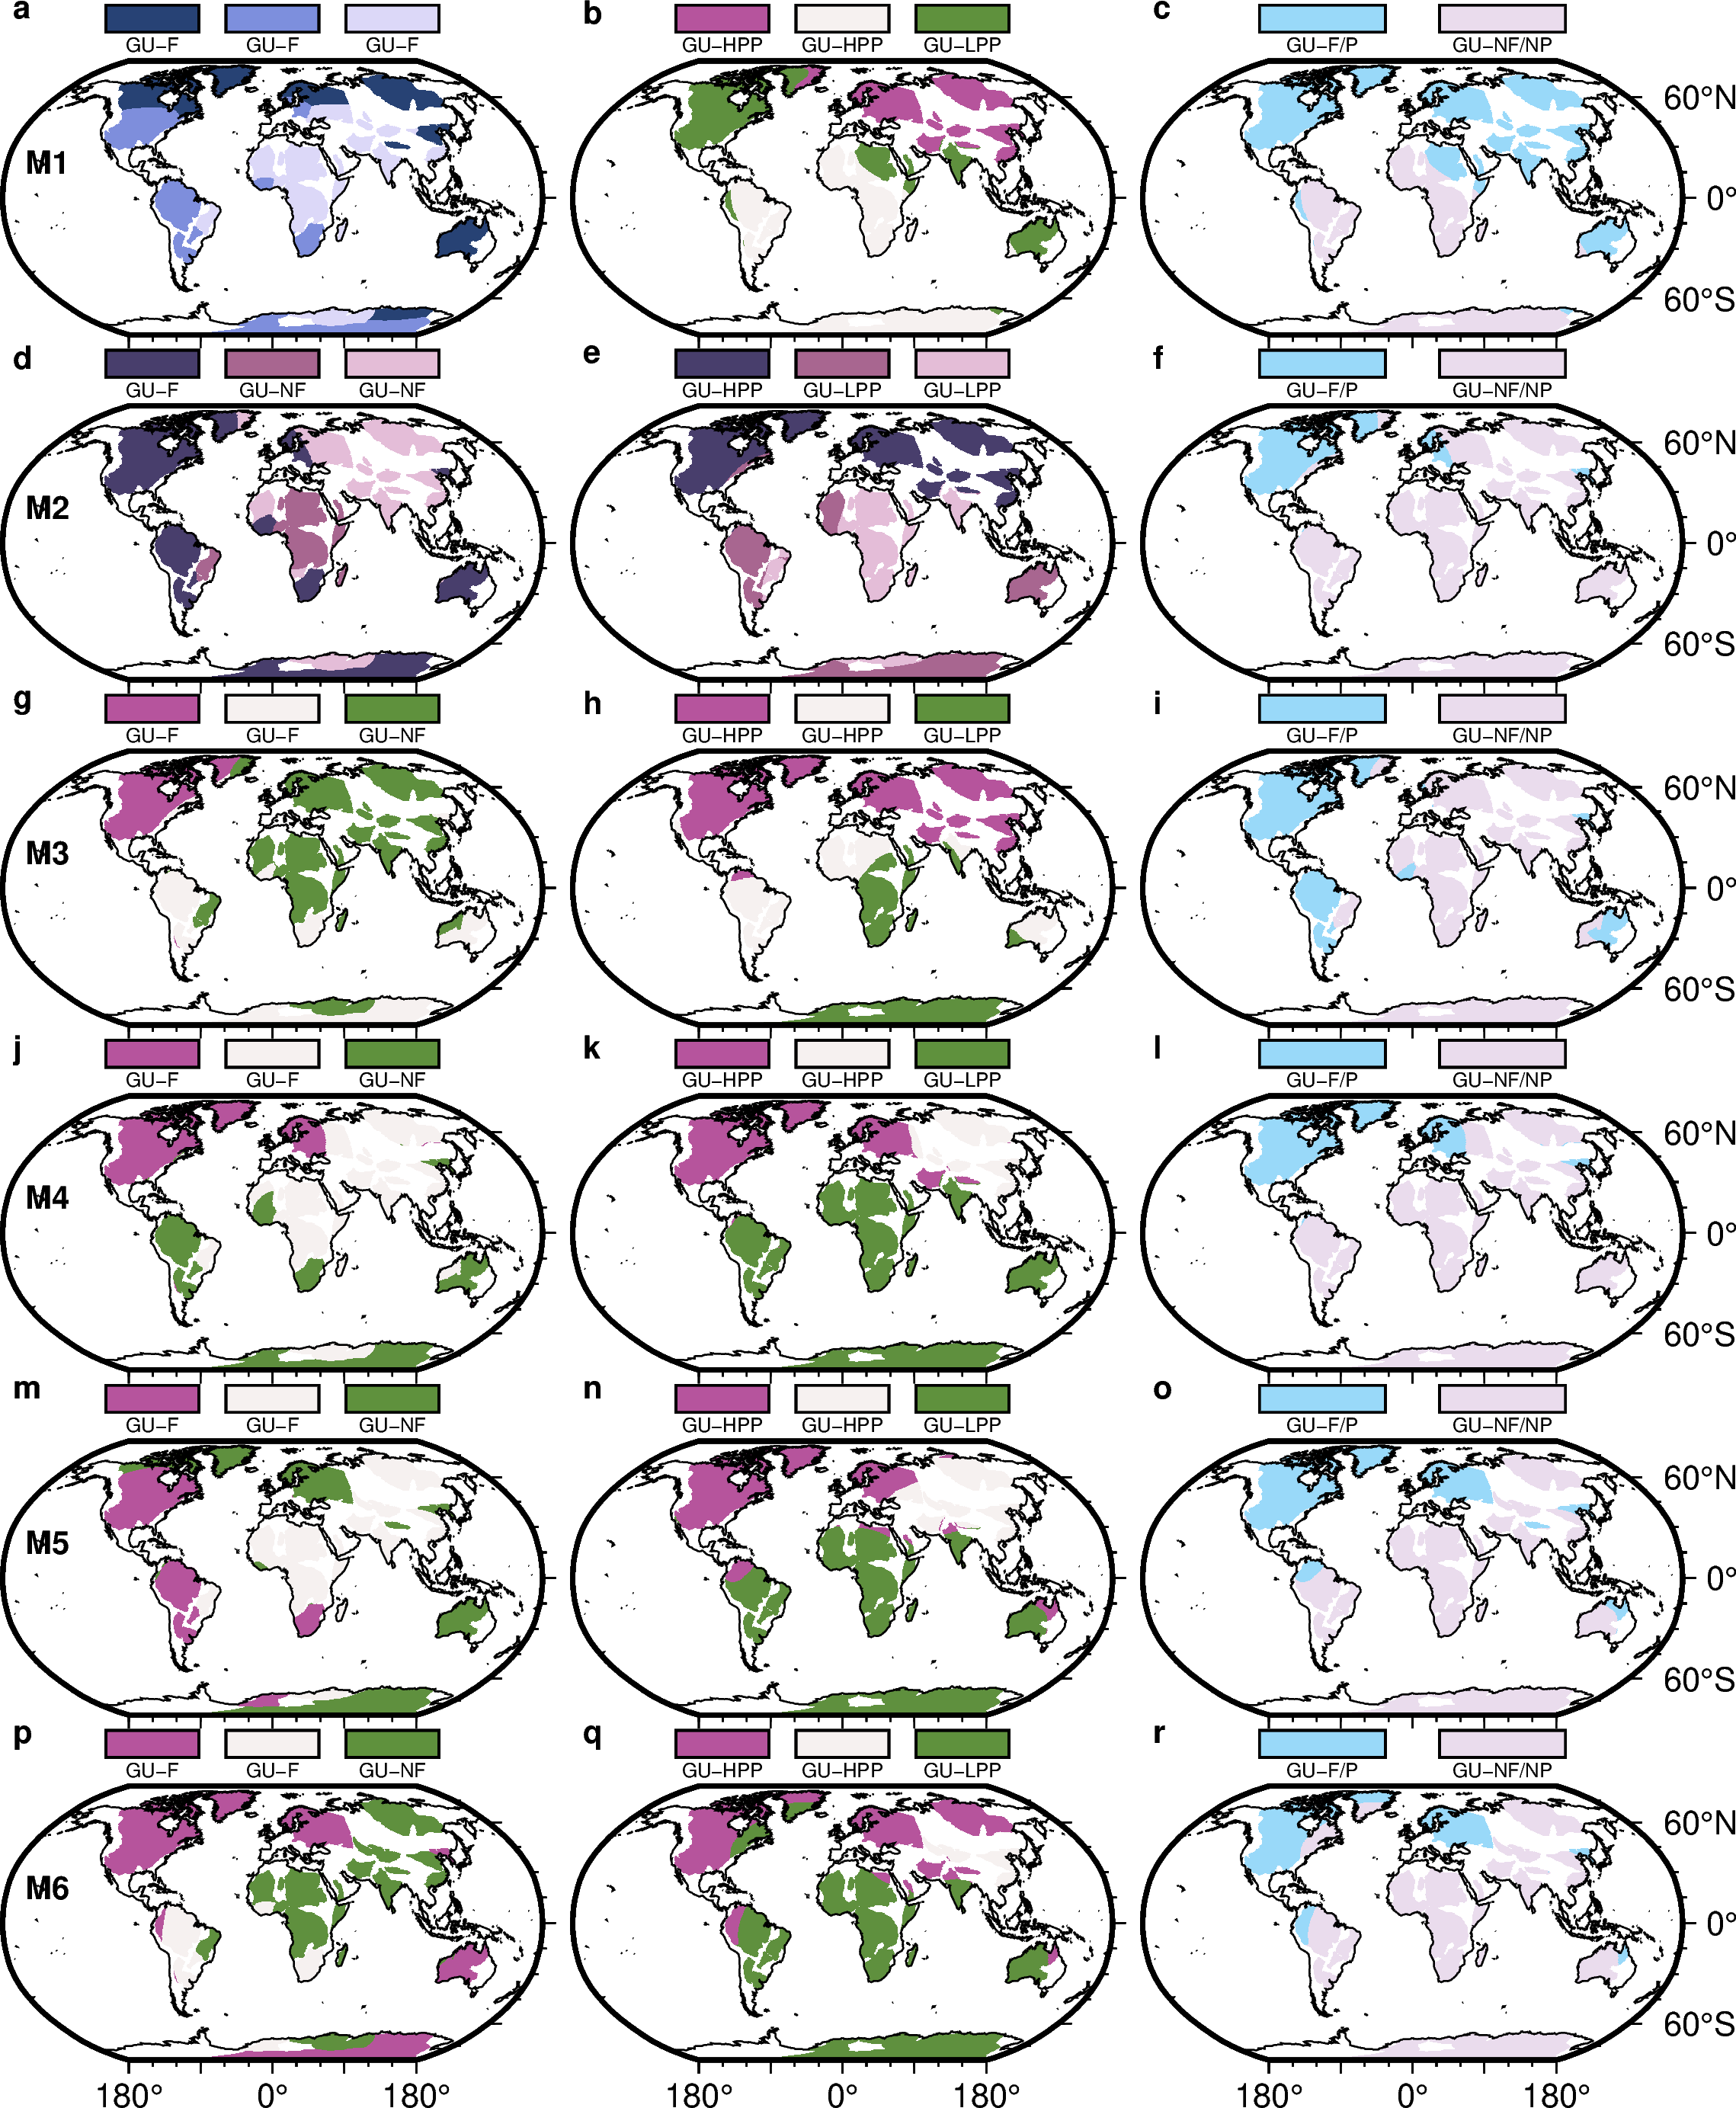

In [67]:
#2-2 mapping for each model
import operator
from functools import reduce

def change_clusters_for_computation(nc, model, age):
    clusters_ = len([ x for x in np.unique(nc.cluster) if not(np.isnan(x))])
    if clusters_==2:
        return nc
    else:
        if age =='420-920':
            
           if model =='gld421':
               nc = nc.where((nc==1) | nc.isnull(), 1)
           elif  model =='gld428':
               nc = nc.where((nc<2) | nc.isnull(), 0)
           else:
               nc = nc.where((nc<2) | nc.isnull(), 1)
    
        else:
            if (model =='gld421') | (model=='gld431') :
                nc = nc.where((nc>0) | nc.isnull(), 1)
                nc = nc.where((nc<2)  | nc.isnull(), 0)
            elif model =='gld428':
                nc = nc.where((nc<2) | nc.isnull(),0)
            else:
                nc = nc.where((nc<2) | nc.isnull(), 1)
    
        return nc

# for plotting
def swapping_clusters_forplot(dataset, model, age):

    clusters_ = len([ x for x in np.unique(dataset.cluster) if not(np.isnan(x))])
    #print(clusters_)
    if clusters_ ==2:
        # cmap = "#FFB300,#A6BDD7"
        # color_model= "+cGU-F,GU-NF"
        mapping ={
            'gld421' : {0:1},
            'gld428' : {0:1},
            'gld431' : {0:1},
            'gld434' : {0:1},
            'gld486' : {0:1},
            'gld504' : {0:1},
            
        }
        color_model= {
            'gld421' : "+cGU-F,GU-NF",
            'gld428' : "+cGU-F,GU-NF",
            'gld431' : "+cGU-F,GU-NF",
            'gld434' : "+cGU-F,GU-NF",
            'gld486' : "+cGU-F,GU-NF",
            'gld504' : "+cGU-F,GU-NF",
            
        }
        cmap= {
            'gld421' : "SCM/bam",
            'gld428' : "SCM/bam",
            'gld431' : "SCM/bam",
            'gld434' : "SCM/bam",
            'gld486' : "SCM/bam",
            'gld504' : "SCM/bam", 
            }
        
        
    else:
        
        if age == '420-920':
            mapping ={
                'gld421' : {0:2, },
                'gld428' : {0:2, 0:1 },
                'gld431' : {0:1, 1:2 },
                'gld434' : { 0:2, 0:1},
                'gld486' : { 0:2, 0:1},
                'gld504' : {0:1,1:2},
                
            }
            
            color_model= {
                'gld421' : "+cGU-F,GU-F,GU-F",
                'gld428' : "+cGU-F,GU-NF,GU-NF",
                'gld431' : "+cGU-F,GU-F,GU-NF",
                'gld434' : "+cGU-F,GU-F,GU-NF",
                'gld486' : "+cGU-F,GU-F,GU-NF",
                'gld504' : "+cGU-F,GU-F,GU-NF",
                
            }
            cmap= {
                'gld421' : "SCM/devon",
                'gld428' : "SCM/acton",
                'gld431' : "SCM/bam",
                'gld434' : "SCM/bam",
                'gld486' : "SCM/bam",
                'gld504' : "SCM/bam",
                
            }
            
        else:
            
            mapping ={
                'gld421' : {0:1, 1:2},
                'gld428' : {0:1, 1:2},
                'gld431' : {0:1, },
                'gld434' : { 0:2},
                'gld486' : { 0:2},
                'gld504' : {0:1, 1:2,},
                
            }
            #cmap= "gmt/cyclic"
            color_model= {
                'gld421' : "+cGU-HPP,GU-HPP,GU-LPP",
                'gld428' : "+cGU-HPP,GU-LPP,GU-LPP",
                'gld431' : "+cGU-HPP,GU-HPP,GU-LPP",
                'gld434' : "+cGU-HPP,GU-HPP,GU-LPP",
                'gld486' : "+cGU-HPP,GU-HPP,GU-LPP",
                'gld504' : "+cGU-HPP,GU-HPP,GU-LPP",
                
            }

            cmap= {
                'gld421' : "SCM/bam",
                'gld428' : "SCM/acton",
                'gld431' : "SCM/bam",
                'gld434' : "SCM/bam",
                'gld486' : "SCM/bam",
                'gld504' : "SCM/bam",
                
            }
            
        
            
    mapping_model =mapping[model]
    if mapping_model:
        for rep_a, rep_b in mapping_model.items():
            #print(f'model:{model}, {rep_a}, {rep_b}, {age_}')
            dataset = swap_clusters(dataset, rep_a, rep_b, var_to_replace='cluster' )
    
        return dataset, cmap[model], color_model[model]
    else:
        return dataset, cmap[model], color_model[model]

        

models =[ 'gld421','gld428', 'gld431', 'gld434', 'gld486', 'gld504']
model_labels =['M1', 'M2', 'M3', 'M4', 'M5', 'M6']
projection = "N6c"
age=0
nclusters_full =[[2,2], [2,3], [3,2], [3,3]]
cluster_combination_final_binary = {}

for nclusters in nclusters_full:

    fig = pygmt.Figure()
    
    
    nc_formation_preservation =[]
    with fig.subplot(nrows=6, ncols=3, figsize=("19c", "23c"), frame="lrtb", margins=["0p", "0p"],
            sharex="b", sharey="r", autolabel='a',):
    
        for m, model in enumerate(models):
            
            #loop = [(i, i%2) for i in range(6)]
            pygmt.config(MAP_HEADING_OFFSET="0p", MAP_TITLE_OFFSET="-12p",
                         FONT_TITLE="10p,Helvetica-Bold,black", FONT_HEADING="16p,Helvetica-Bold,black", FONT_TAG="10p, Helvetica-Bold, black",) 
        
            
            #---------------------------------prepare datasets----------------------------------------#
            age_range=['420-920', '0-420']
        
            computation_datasets = []
            mapping_datasets =[]
            cmaps =[]
            color_models=[]
            
            for k, age_ in enumerate(age_range):
                
                cluster_fpath = f'ClusterAnalysis/cluster_{model}_{age_}_{nclusters[k]}.nc'
                cluster = xr.open_dataset(cluster_fpath)
                mapping_cluster= cluster.copy()
                
                computation_datasets.append(change_clusters_for_computation(cluster, model, age_))
                mapped_cluster, cm, color_mod = swapping_clusters_forplot(mapping_cluster, model, age_)
                mapping_datasets.append(mapped_cluster)
                cmaps.append(cm)
                color_models.append(color_mod)
                
        
            #----------------------Elementwise multiplication of formation nc and preservation nc----------------------------#
            nc_preservation = reduce(operator.mul, computation_datasets).cluster
            nc_pres= nc_preservation.to_dataset(name='cluster')
            nc_pres = swap_clusters(nc_pres, 0, 1, var_to_replace='cluster' )
    
            nc_formation_preservation.append(nc_pres)
            nc_pres_color_map =['#99D9F9,#EADCED']
            nc_pres_color_model =['+cGU-F/P,GU-NF/NP']
            
            datasets =mapping_datasets+ [nc_pres] 
            cmaps = cmaps+nc_pres_color_map
            color_models =color_models+nc_pres_color_model
    
    
            for j in range(len(datasets)):
                
            
                #--------------------------------Cluster Plots--------------------------------------#
               
                with fig.set_panel(panel=[m, j], ):  #clearance=['n-0.75c','s1.25c']
    
                    #cluster = nc_preservation
                    nclusters_ = len([ x for x in np.unique(datasets[j].cluster) if not(np.isnan(x))])
                    #print('j=', j, nclusters_, np.unique(datasets[j].cluster), cmaps[j])
                    if nclusters_ ==1:
                        series_cl = [0, nclusters_, 1] 
                    else:
                        series_cl = [0, nclusters_ -1, 1] 
                    pygmt.makecpt(cmap=cmaps[j], series=series_cl, color_model= color_models[j] )
                  
                    # #-------------------------------swap clusters only for plotting---------------------------------------------------#
                    # cluster_swapped =swapping_clusters_forplot(datasets[j], model)
                    land_mask_file = glob.glob('./orogens/ne*/*shp')
                    
                    datasets[j]=datasets[j].rio.write_crs("epsg:4326", inplace=True).rename({'lon':'x', 'lat':'y'})
                    masked_dataset=datasets[j].rio.clip(geometries=land_mask.geometry, crs=4326, all_touched=True)
                    fig.grdimage(grid=masked_dataset.cluster, projection=projection, region= 'd', nan_transparent="+znan",  cmap=True , frame=None, verbose='q')
                    fig.coast(shorelines="1/0.5p", region='d', projection=projection , verbose='q')
    
                    if j==0:
                        fig.text(
                                text=f"{model_labels[int(m)]}",
                                position="ML",  # Top Left
                                font ='10p,Helvetica-Bold, black',
                                justify="ML",  # Top Left
                                offset=['0.25/0'],
                                no_clip=True
                            )
                        
                    
                    fig.basemap(region='d', projection=projection, frame= ["etls",f"xaf", "yaf"])
    
                   # if m==5:
                
                    with pygmt.config(FONT_ANNOT_PRIMARY='12p'):
                        fig.colorbar(cmap=True, position="x3c/3.35c+w4c/0.3c+jTC+h", verbose='q')
                        #fig.colorbar(cmap=True, position="x3c/-0.75c+w4c/0.3c+jTC+h+e+ml", verbose='q')   #org
                    
                
    cluster_combination_final_binary["x".join(map(str, nclusters))] =   nc_formation_preservation     
    if model=='gld504':
        fig.savefig(f'./ExtendedDataFigures/EDF5_{model}_GU_formation_preservation_orogens_{nclusters}.pdf', dpi=600, resize='+s18.2c')
fig.show()


[ 2.  3.  4.  5.  6. nan]
[ 2.  3.  4.  5.  6. nan]
[ 2.  3.  4.  5.  6. nan]
[ 2.  3.  4.  5.  6. nan]


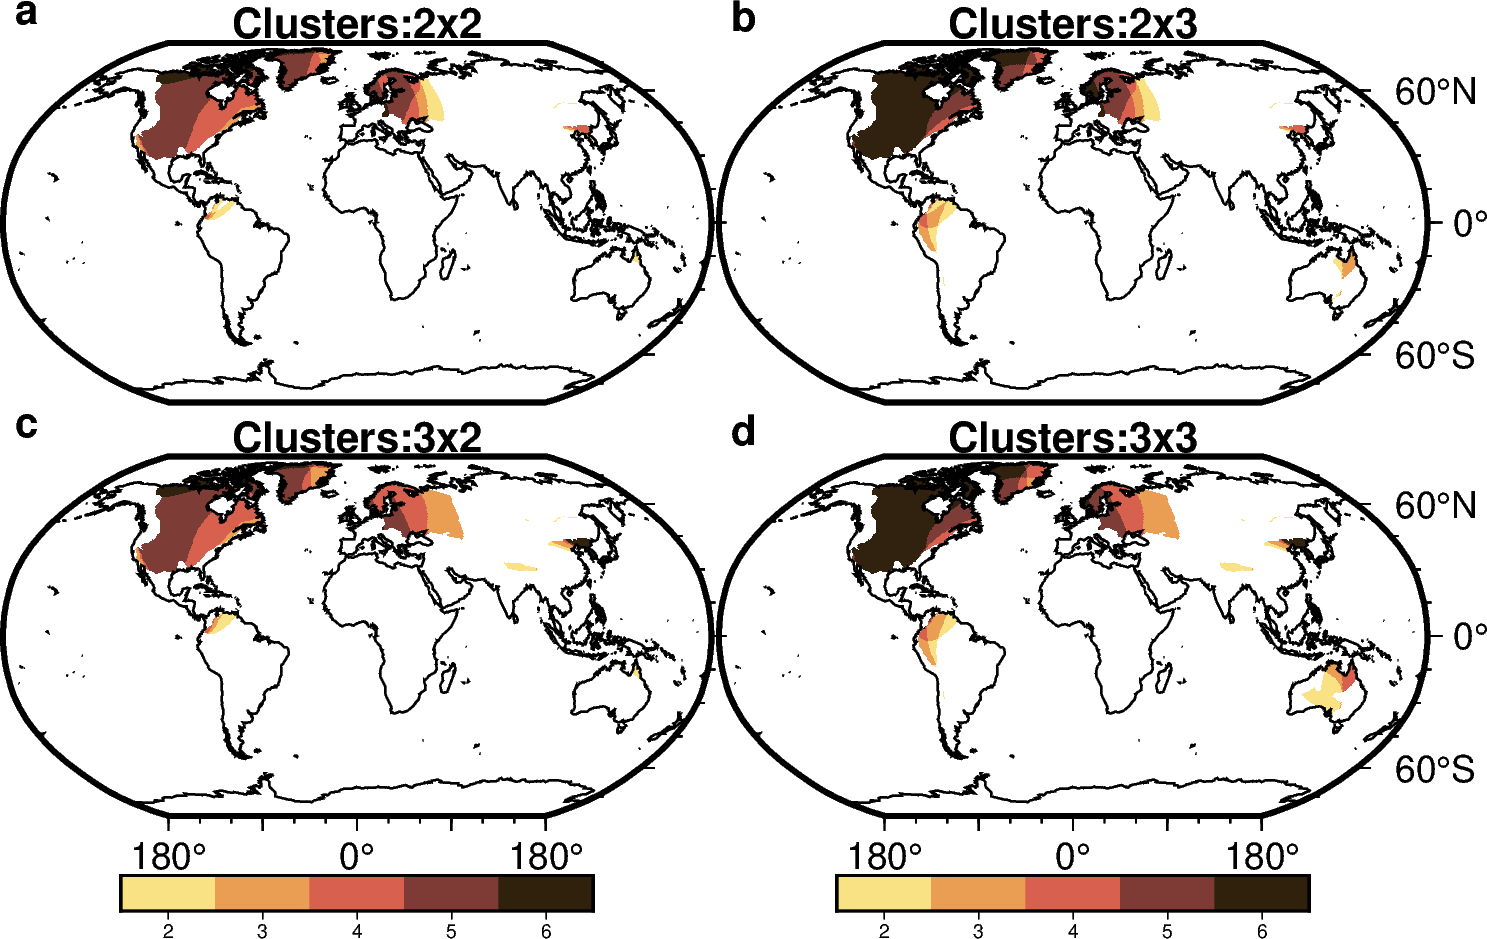

In [68]:
#cluster_combination_final_binary
projection ='N6c'
fig_final= pygmt.Figure()
with fig_final.subplot(nrows=2, ncols=2, figsize=("12c", "7c"), frame="letb", margins=["0p", "0p"],
            sharex="b", sharey="r", autolabel='a',):
    
    for j, (key, cluster_combination) in enumerate(cluster_combination_final_binary.items()):
                
        #loop = [(i, i%2) for i in range(6)]
        pygmt.config(MAP_HEADING_OFFSET="0p", MAP_TITLE_OFFSET="-11.5p",
                     FONT_TITLE="10p,Helvetica-Bold,black", FONT_HEADING="16p,Helvetica-Bold,black", FONT_TAG="10p, Helvetica-Bold, black",) 
        with fig_final.set_panel(panel=j ):
            # swap clusters for vote map
            vote_clusters = [ swap_clusters(raw_data, 1, 0, var_to_replace='cluster') for  raw_data in cluster_combination_final_binary[key]]
            #final_f_p = reduce(operator.add, cluster_combination_final_binary[key])
            final_f_p = reduce(operator.add, vote_clusters)
           
            
            da = final_f_p.cluster
            
            da = xr.where(da>1,da, np.nan)
            print(np.unique(da))
            final_binary =xr.where(da > 3, 1, xr.where(da <3, 0, np.nan))
            
            
            
            
            pygmt.makecpt(cmap='SCM/lajolla', series=[1.5, 6.5,1],  reverse=True,) # color_model= '+c2-6' )
                          
            # #-------------------------------swap clusters only for plotting---------------------------------------------------#
            # cluster_swapped =swapping_clusters_forplot(datasets[j], model)
            land_mask_file = glob.glob('./orogens/ne*/*shp')
                    
            da=da.rio.write_crs("epsg:4326", inplace=True).rename({'lon':'x', 'lat':'y'})
            masked_da=da.rio.clip(geometries=land_mask.geometry, crs=4326, all_touched=True)
    
            fig_final.grdimage(grid=masked_da, projection=projection, region= 'd', nan_transparent="+znan",  cmap=True , frame=None, verbose='q')
            fig_final.coast(shorelines="1/0.5p", region='d', projection=projection , verbose='q')
            fig_final.basemap(region='d', projection=projection, frame= [f"+tClusters:{key}"])
            
            if j >1:
                fig_final.colorbar(cmap=True, position="x3c/-0.75c+w4c/0.3c+jTC+h+mc", frame =["a1"], verbose='q')
                
fig_final.savefig(f'./ExtendedDataFigures/EDF6_GU_formation_preservation_clusters_combination.pdf', dpi=600, resize='+s18.2c')
fig_final.show()

#0 and 1 to nan